# Bike Sharing

**Models used:** XGBRegressor, RandomForestRegressor, GradientBoostingRegressor

**Feature engineering:** one-hot encoding

**Feature selection:** True

**Feature scaling:** standardization (centering and scaling)

**Outlier identification:** based on LassoCV


## Описание

Вы разрабатываете модель для сервиса краткосрочной аренды велосипедов, у сервиса более 100 станций.

Сервис заинтересован в развитии своих станции и оптимизации своей работы. Для оптимизации сервис хочет получать предсказание количества велосипедов на каждой станции, чтобы минимизироват простой технике и увеличить прибыль.

Вам предлагается набор данных от сервиса, который позволит оценить: количество велосипедов на станциях, время аренды, пиковые часы и часы простоя, как станции связаны между собой.

Оценка модели будет при помощи **RMSE**

Целевая переменная **net_rate**

In [1]:
from __future__ import print_function
from __init__ import *

import os
import math
from functools import partial
from collections import OrderedDict

# база
import numpy as np
import matplotlib.pyplot as plt
import pandas
import pandas as pd
import sklearn
# группа линейная
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lars
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LarsCV
from sklearn.linear_model import LassoLarsIC

# группа ансамблей
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# группа отбора
from sklearn.model_selection import KFold 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve                         

# группа препроцессов
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder                                  
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import make_pipeline

from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from xgboost import XGBRegressor

from skrebate import ReliefF, SURF, SURFstar, MultiSURF, MultiSURFstar, TuRF
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

# отбор
#from feature_selector import FeatureSelector

# визуализация
import shap

In [2]:
# seed один для всех
seed = 42
np.random.seed(seed)
verbose   = 2

In [10]:
# данные о станциях
station_data = pd.read_csv(filepath_or_buffer='{}/data/_station_data.csv'.format(DATA_PATH),
                           sep=',', header=0,
                           names=['Station_id', 'Station', 'Lat', 'Long', 'Dock_Count', 'City', 'Inst_date'])


print('dimensions of station data:',station_data.shape)

# проверка пустот
print('check if any data is missing:', 
      station_data.isnull().values.any())

station_data.head(5)

dimensions of station data: (70, 7)
check if any data is missing: False


Station_id                            Station        Lat        Long  \
0           2  San Jose Diridon Caltrain Station  37.329732 -121.901782   
1           3              San Jose Civic Center  37.330698 -121.888979   
2           4             Santa Clara at Almaden  37.333988 -121.894902   
3           5                   Adobe on Almaden  37.331415 -121.893200   
4           6                   San Pedro Square  37.336721 -121.894074   

   Dock_Count      City Inst_date  
0          27  San Jose  8/6/2013  
1          15  San Jose  8/5/2013  
2          11  San Jose  8/6/2013  
3          19  San Jose  8/5/2013  
4          15  San Jose  8/7/2013

In [3]:
# почтовые коды городов для набора данных
zip_code = {'San Francisco': 94107, 'Redwood City': 94063, 
            'Palo Alto': 94301, 'Mountain View': 94041, 
            'San Jose': 95113}
   
# id новых станций
map_to_old_id = {85: 23, 86: 25, 87: 49, 88: 69, 89: 72, 90: 72}

In [4]:
# получаем имя
def extract_estimator_name(estimator):

    # проверка естиматор == объект pipeline
    if isinstance(estimator, sklearn.pipeline.Pipeline):
        data_type = type(estimator._final_estimator)

    # проверка естиматор == grid search объект
    elif isinstance(estimator, sklearn.model_selection._search.GridSearchCV):
        # проверка естиматор == объект pipeline
        if isinstance(estimator.best_estimator_, sklearn.pipeline.Pipeline):
            data_type = type(estimator.best_estimator_._final_estimator)

        else:
            data_type = type(estimator.best_estimator_)

    # если это не pipeline и не grid search объект
    else:
        data_type = type(estimator)

    name = ''.join(filter(str.isalnum, str(data_type).split('.')[-1]))

    return name

In [23]:
# Кросс-валидаия k-fold
def grid_search(estimator, 
                X, 
                y, 
                outer_cv, 
                inner_cv,
                param_grid, 
                scoring='accuracy',
                n_jobs=1, 
                debug=False):
    """
    Nested k-fold cross-validation

    Parameters
    ----------
    estimator : array, shape = [n_samples]
         true class, integers in [0, n_classes - 1)
    X : array,   shape = [n_samples, n_classes]
    y : array,   shape = [n_samples, n_classes]
    outer_cv :   shape = [n_samples, n_classes]
    inner_cv :   shape = [n_samples, n_classes]
    param_grid : shape = [n_samples, n_classes]
    scoring :    shape = [n_samples, n_classes]
    n_jobs : int, default 1
    debug : boolean, default Fasle

    Returns
    -------
    grid : GridSearchCV object
        A post-fit (re-fitted to full dataset) GridSearchCV 
        object where the estimator is a Pipeline.
    """

    outer_scores = []

    # имя модели
    name = extract_estimator_name(estimator).lower()

    # установка конфига для поиска
    grid = GridSearchCV(estimator=estimator, param_grid=param_grid,
                        cv=inner_cv, scoring=scoring, n_jobs=n_jobs)

    # разделение трайн-треста
    for k, (training_samples, test_samples) in enumerate(outer_cv.split(X, y)):

        # x 
        if isinstance(X, pd.DataFrame):
            x_train = X.iloc[training_samples]
            x_test = X.iloc[test_samples]
        else:
            x_train = X[training_samples]
            x_test = X[test_samples]

        # y 
        if isinstance(y, pd.Series):
            y_train = y.iloc[training_samples]
            y_test = y.iloc[test_samples]
        else:
            y_train = y[training_samples]
            y_test = y[test_samples]

        # Строим классификатор на лучших параметрах
        print('fold-', k+1, 'model fitting...')

        grid.fit(x_train, y_train)

        # получаем параметры лучшей модели
        if debug:
            print('\n\t', grid.best_estimator_.get_params()[name])

        # оценка качества 
        score = grid.score(x_test, y_test)

        outer_scores.append(abs(score))
        print('\n\tModel validation score:', abs(score), '\n')

    
    print('\nHyper-paramters of best model:\n\n',
          grid.best_estimator_.get_params()[name])

    print('\nFinal model evaluation (mean cross-val scores):',
          np.array(outer_scores).mean())

    return grid

In [6]:
# отрисовка learning-curve
def plot_learning_curve(estimator, 
                        title, 
                        X, 
                        y, 
                        ylim=None,
                        cv=None,
                        scoring=None, 
                        n_jobs=1, 
                        train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    scoring : string

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).

    train_sizes : array-like
    """
    
    train_sizes, train_scores, test_scores = learning_curve(
                 estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs,
                 train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(8, 6))
        
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='r')
    
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='g')
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',
             label='Training score')
    
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g',
             label='Cross-validation score')
    
    plt.title(title)
        
    plt.xlabel('Training sample size')
    plt.ylabel('Score: '+scoring)
    
    if ylim is not None:
        plt.ylim(*ylim)
    
    plt.legend(loc='best')
    
    return display(plt.show())


In [7]:
# Определяем функцию для проверки качества: RMSE
def rmse_cv(model, X, y, scorer='neg_mean_squared_error'):
    rmse= np.sqrt(-cross_val_score(model, 
                                   X, y, 
                                   scoring=scorer, 
                                   cv = 3))
    return rmse

In [8]:
# функции для создания фичей
def f_sine(t, T): return math.sin(2*math.pi*t/T)
def f_cosine(t, T): return math.cos(2*math.pi*t/T)

##  Load Data


In [ ]:
# данные о станциях
station_data = pd.read_csv(filepath_or_buffer='data/_station_data.csv',
                           sep=',', header=0,
                           names=['Station_id', 'Station', 'Lat', 'Long', 'Dock_Count', 'City', 'Inst_date'])


print('dimensions of station data:',station_data.shape)

# проверка пустот
print('check if any data is missing:', 
      station_data.isnull().values.any())

station_data.head(5)

In [ ]:
# данные о путешествиях на арендованных велосипедах
trip_data = pd.read_csv(filepath_or_buffer='data/trip_data.csv', sep=',',
                        infer_datetime_format=True, dayfirst=True,
                        parse_dates=['Start_Date', 'End_Date']
                        )[['Trip_ID', 'Start_Date', 'Start_Station', 'End_Date', 'End_Station', 'Subscriber_Type']]


print('dimension of trip data:',trip_data.shape)
print('check if any data is missing:',trip_data.isnull().values.any())


trip_data.head(5)

In [ ]:
# данные о погоде
weather_data = pd.read_csv(filepath_or_buffer='data/weather_data.csv',
                           sep=',', infer_datetime_format=True, 
                           dayfirst=True,
                           parse_dates=['Date'])

print('dimension of trip data:', weather_data.shape)
print('check if any data is missing:', weather_data.isnull().values.any())

weather_data.head(5)

## Data Cleaning


In [ ]:
# Оригинальные события
set(weather_data['Events'])

In [ ]:
# NaN => 'Clear'
weather_data['Events'] = weather_data['Events'].fillna('Clear')

- Данные, которые не могут быть пустые нужно заполнить. Это температура, ветеh и осатдки

- Остальные заполняем в случае использования или если алгоритм воспринимает пустоты, то оставляем их не заполненными

In [ ]:
# О погоде заполняем стредними значениями
mean_weather_data = weather_data.set_index(['Date'])\
                                .sort_index()\
                                .groupby(level=['Date']).mean()
        
weather_data = weather_data.set_index(['Date'])\
                           .sort_index()\
                           .fillna(value=mean_weather_data, axis=0)

weather_data = weather_data.sort_index()\
                           .interpolate(method='time')\
                           .reset_index()

## Data Transformations

Преобразуем города в их код, есть ещё варианты переделать в категории

In [ ]:
# zio <= City
station_data['Zip'] = station_data['City'].map(zip_code)

# Удаляем  или делаем реплейс лишниих
station_data.drop(['Lat', 'Long', 'City'], inplace=True, axis=1)
station_data['Station'].replace(to_replace=map_to_old_id, inplace=True)
trip_data['Start_Station'].replace(to_replace=map_to_old_id, inplace=True)
trip_data['End_Station'].replace(to_replace=map_to_old_id, inplace=True)
station_data.drop_duplicates(inplace=True)

## Data Aggregation


In [77]:
# Делаем таблицу с мультИндексами по ID|trip date 

# https://stackoverflow.com/questions/28132668/
# how-can-i-keep-this-pandas-column-type-as-datetime-when-using-multiindex
idx = pd.MultiIndex\
        .from_product([station_data['Station'].sort_values().unique(),
                       pd.Index(pd.date_range('2014-09-01 00:00:00',
                                             '2015-08-31 23:00:00', 
                                             freq='H'))],
                      names=['Station', 'Datetime'])

In [78]:
# Делаем ресемплинг по времени (агрегат по часу)
end_trip_data = trip_data.groupby(['End_Station'])\
                         .resample('H', on='End_Date')\
                         .size().to_frame().rename(columns={0: 'num_trips'})\
                         .reindex(idx, fill_value=0)

start_trip_data = trip_data.groupby(['Start_Station'])\
                            .resample('H', on='Start_Date')\
                            .size().to_frame().rename(columns={0: 'num_trips'})\
                            .reindex(idx, fill_value=0)

In [79]:
# Соединяем данные по времени поездки
trip_data_agg = end_trip_data.merge(start_trip_data,
                                    left_index=True, right_index=True,
                                    suffixes=('_end', '_start'))

In [80]:
trip_data_agg.iloc[range(31,35)]

num_trips_end  num_trips_start
Station       Datetime                                           
2nd at Folsom 2014-09-02 07:00:00              0                1
              2014-09-02 08:00:00              3                2
              2014-09-02 09:00:00              3                6
              2014-09-02 10:00:00              0                1

In [81]:
# извлекаем дни
trip_data_agg['Date'] = pd.Series(trip_data_agg.index.get_level_values('Datetime').date)\
                          .apply(pd.Timestamp).to_frame().set_index(idx)

# извлекаем часы
trip_data_agg['Hour'] = trip_data_agg.index.get_level_values('Datetime').hour.values

In [82]:
trip_data_agg

num_trips_end  \
Station                                       Datetime                             
2nd at Folsom                                 2014-09-01 00:00:00              0   
                                              2014-09-01 01:00:00              0   
                                              2014-09-01 02:00:00              0   
                                              2014-09-01 03:00:00              0   
                                              2014-09-01 04:00:00              0   
...                                                                          ...   
Yerba Buena Center of the Arts (3rd @ Howard) 2015-08-31 19:00:00              0   
                                              2015-08-31 20:00:00              0   
                                              2015-08-31 21:00:00              0   
                                              2015-08-31 22:00:00              0   
                                              2015-08-31 23:00:00              0   

                                                                   num_trips_start  \
Station                                       Datetime                               
2nd at Folsom                                 2014-09-01 00:00:00                0   
                                              2014-09-01 01:00:00                0   
                                              2014-09-01 02:00:00                0   
                                              2014-09-01 03:00:00                0   
                                              2014-09-01 04:00:00                0   
...                                                                            ...   
Yerba Buena Center of the Arts (3rd @ Howard) 2015-08-31 19:00:00                1   
                                              2015-08-31 20:00:00                3   
                                              2015-08-31 21:00:00                0   
                                              2015-08-31 22:00:00                0   
                                              2015-08-31 23:00:00                1   

                                                                        Date  \
Station                                       Datetime                         
2nd at Folsom                                 2014-09-01 00:00:00 2014-09-01   
                                              2014-09-01 01:00:00 2014-09-01   
                                              2014-09-01 02:00:00 2014-09-01   
                                              2014-09-01 03:00:00 2014-09-01   
                                              2014-09-01 04:00:00 2014-09-01   
...                                                                      ...   
Yerba Buena Center of the Arts (3rd @ Howard) 2015-08-31 19:00:00 2015-08-31   
                                              2015-08-31 20:00:00 2015-08-31   
                                              2015-08-31 21:00:00 2015-08-31   
                                              2015-08-31 22:00:00 2015-08-31   
                                              2015-08-31 23:00:00 2015-08-31   

                                                                   Hour  
Station                                       Datetime                   
2nd at Folsom                                 2014-09-01 00:00:00     0  
                                              2014-09-01 01:00:00     1  
                                              2014-09-01 02:00:00     2  
                                              2014-09-01 03:00:00     3  
                                              2014-09-01 04:00:00     4  
...                                                                 ...  
Yerba Buena Center of the Arts (3rd @ Howard) 2015-08-31 19:00:00    19  
                                              2015-08-31 20:00:00    20  
                                              2015-08-31 21:00:00    21  


## Net Rate

Оцениваем чистую тарифную ставку (net rate)

### Хороший вариант

In [83]:
trip_data_agg.eval('net_rate=num_trips_end-num_trips_start', inplace=True)
trip_data_agg.drop(['num_trips_end', 'num_trips_start'], inplace=True, axis=1)

trip_data_agg

Date  \
Station                                       Datetime                         
2nd at Folsom                                 2014-09-01 00:00:00 2014-09-01   
                                              2014-09-01 01:00:00 2014-09-01   
                                              2014-09-01 02:00:00 2014-09-01   
                                              2014-09-01 03:00:00 2014-09-01   
                                              2014-09-01 04:00:00 2014-09-01   
...                                                                      ...   
Yerba Buena Center of the Arts (3rd @ Howard) 2015-08-31 19:00:00 2015-08-31   
                                              2015-08-31 20:00:00 2015-08-31   
                                              2015-08-31 21:00:00 2015-08-31   
                                              2015-08-31 22:00:00 2015-08-31   
                                              2015-08-31 23:00:00 2015-08-31   

                                                                   Hour  \
Station                                       Datetime                    
2nd at Folsom                                 2014-09-01 00:00:00     0   
                                              2014-09-01 01:00:00     1   
                                              2014-09-01 02:00:00     2   
                                              2014-09-01 03:00:00     3   
                                              2014-09-01 04:00:00     4   
...                                                                 ...   
Yerba Buena Center of the Arts (3rd @ Howard) 2015-08-31 19:00:00    19   
                                              2015-08-31 20:00:00    20   
                                              2015-08-31 21:00:00    21   
                                              2015-08-31 22:00:00    22   
                                              2015-08-31 23:00:00    23   

                                                                   net_rate  
Station                                       Datetime                       
2nd at Folsom                                 2014-09-01 00:00:00         0  
                                              2014-09-01 01:00:00         0  
                                              2014-09-01 02:00:00         0  
                                              2014-09-01 03:00:00         0  
                                              2014-09-01 04:00:00         0  
...                                                                     ...  
Yerba Buena Center of the Arts (3rd @ Howard) 2015-08-31 19:00:00        -1  
                                              2015-08-31 20:00:00        -3  
                                              2015-08-31 21:00:00         0  
                                              2015-08-31 22:00:00         0  
                                              2015-08-31 23:00:00        -1  

[613200 rows x 3 columns]

### Чей-то старый код из git команды

0it [00:00, ?it/s]

Total hours from  2014-09-01 00:00:00  to  2015-08-31 23:00:00 : 8760


354152it [02:25, 2428.82it/s]
100%|███████████████████████████████████████████████████████████████████████████| 8760/8760 [00:00<00:00, 46414.17it/s]

190219
167166



  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

190219
32 2316
57 4603


 50%|█████████████████████████████████████████▌                                         | 1/2 [03:40<03:40, 220.86s/it]

422981
2 2717
18 2014
15 7215
51 7782
31 5999


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [08:17<00:00, 248.70s/it]


                                      id_station  id_date  dow  id_hour  hour  \
0                                Clay at Battery       96    5     2316    12   
1                Santa Clara County Civic Center      346    3     8316    12   
2  Yerba Buena Center of the Arts (3rd @ Howard)      317    2     7628    20   
3                          San Jose Civic Center       31    3      751     7   
4  Yerba Buena Center of the Arts (3rd @ Howard)       50    1     1212    12   

   num_trips_start  hours_since_last_start  num_trips_end  \
0              2.0                      15            0.0   
1              2.0                      19            0.0   
2              1.0                       3            0.0   
3              1.0                      24            0.0   
4              4.0                       2            3.0   

   hours_since_last_end  net_rate  
0                    16      -2.0  
1                     4      -2.0  
2                     1      -1.0  
3 

array([[<AxesSubplot:title={'center':'net_rate'}>]], dtype=object)

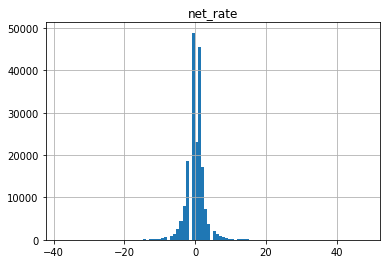

In [23]:
from scipy.sparse import csr_matrix, dok_matrix
import datetime
#from datetime import datetime
from tqdm import tqdm


num_stations = station_data['Station'].count()
station_ids = station_data['Station'].values
sid2id = {station_ids[i]: i for i in range(num_stations)}
min_date = trip_data['Start_Date'].min()
min_date = min_date.replace(minute=0, second=0)
max_date = trip_data['End_Date'].max()
max_date = max_date.replace(minute=0, second=0)
time_delta = max_date - min_date
total_hours = int(time_delta.total_seconds() / 3600) + 1
print('Total hours from ', min_date, ' to ', max_date, ': %d' %total_hours)

list_date = weather_data['Date'].dt.date
min_date_w, max_date_w = list_date.min(), list_date.max()
num_days = (max_date_w - min_date_w).days + 1
num_days = (max_date_w - min_date_w).days + 1
map_date2id = {(min_date_w+ datetime.timedelta(days=idx)): idx for idx in range(num_days)}
weather_data['id_date'] = [map_date2id[date] for date in list_date]

# create matrix start station, end station, duration of trips
start_matrix = dok_matrix((num_stations, total_hours))
end_matrix = dok_matrix((num_stations, total_hours))
# duration_matrix = dok_matrix((num_stations, total_hours))
for idx, row in tqdm(trip_data.iterrows()):
    try:
        start_station_id = row['Start_Station']
        start_date = row['Start_Date'].replace(minute=0, second=0)
        delta = start_date - min_date
        start_id_col = int(delta.total_seconds() / 3600)
        start_id_row = sid2id[start_station_id]
        start_matrix[start_id_row, start_id_col] += 1

        end_station_id = row['End_Station']
        end_date = row['End_Date'].replace(minute=0, second=0)
        delta = end_date - min_date
        end_id_col = int(delta.total_seconds() / 3600)
        end_id_row = sid2id[end_station_id]
        end_matrix[end_id_row, end_id_col] += 1
    except: pass
    
start_keys = list(start_matrix.keys())
end_keys = list(end_matrix.keys())
total_keys = set([(row, col) for row in range(num_stations) for col in range(total_hours)])
positive_output_keys = set(start_keys + end_keys)
negative_output_keys = total_keys - positive_output_keys
positive_output_keys = list(positive_output_keys)
negative_output_keys = list(negative_output_keys)

# output considered as predicted variables, and only consider value at key in list postive_output_keys
output = end_matrix - start_matrix
print(len(positive_output_keys))
print(len(output.nonzero()[0]))

# construct table of predicted values
map_idhour2date = dict()
for id_hour in tqdm(range(total_hours)):
    map_idhour2date[id_hour] = min_date + datetime.timedelta(hours=id_hour)
postitive_stations_hour = list()
negative_stations_hour = list()
id_count = 0
dict_col_nonzero_start = {row: start_matrix[row].nonzero()[1] for row in range(start_matrix.shape[0])}
dict_col_nonzero_end = {row: end_matrix[row].nonzero()[1] for row in range(end_matrix.shape[0])}
# for row, col in positive_output_keys:
for keys, station_hour in tqdm([([positive_output_keys, postitive_stations_hour]), (negative_output_keys, negative_stations_hour)]):
    print(len(keys))
    for row, col in keys:
        
        if id_count%100000 == 0:
            print(row, col)
        id_count += 1
        id_station = station_ids[row]
        date = map_idhour2date[col]
        id_date = map_date2id[date.date()]
        hour = date.hour
        dow = date.weekday() # day of week
        hours_since_last_start = 0
        hours_since_last_end = 0
        from time import time
#     t1 = time()
        col_nonzero_start = dict_col_nonzero_start[row] #start_matrix[row].nonzero()
#     t2 = time()
        try:
            if min(col_nonzero_start) < col:
                idx = np.where(col_nonzero_start < col)[0][-1]
                hours_since_last_start = col - col_nonzero_start[idx]
    #     t3 = time()
    #     print(t2-t1, t3-t2)
            col_nonzero_end = dict_col_nonzero_end[row] #end_matrix[row].nonzero()
            if min(col_nonzero_end) < col:
                idx = np.where(col_nonzero_end < col)[0][-1]
                hours_since_last_end = col - col_nonzero_end[idx]

            station_hour.append([id_station, id_date, dow, col, hour, start_matrix[row, col], hours_since_last_start, end_matrix[row, col], hours_since_last_end, output[row, col]])
        except: pass
            
df_positive = pd.DataFrame(postitive_stations_hour, columns=['id_station', 'id_date', 'dow', 'id_hour', 'hour', 'num_trips_start', 'hours_since_last_start', 'num_trips_end', 'hours_since_last_end', 'net_rate'])
df_negative = pd.DataFrame(negative_stations_hour, columns=['id_station', 'id_date', 'dow', 'id_hour', 'hour', 'num_trips_start', 'hours_since_last_start', 'num_trips_end', 'hours_since_last_end', 'net_rate'])
print(df_positive.head())
print(df_negative['num_trips_start'].unique(), df_negative['num_trips_end'].unique(), df_negative['net_rate'].unique())
df_positive.hist(column='net_rate', bins=100)

## Data Augmentation

Соединяем данные погоды к агрегату по аренде

In [84]:
# данные по станциям
trip_data_agg = trip_data_agg.join(station_data.set_index('Station'))

In [85]:
# погода
trip_data_agg.reset_index(inplace=True)
trip_data_agg.set_index(['Date', 'Zip'], inplace=True)

weather_data.set_index(['Date', 'Zip'], inplace=True)

trip_data_agg = trip_data_agg.join(weather_data)\
                             .reset_index()\
                             .set_index(['Station', 'Datetime'])

In [86]:
trip_data_agg

Date    Zip  Hour  \
Station                          Datetime                                      
Castro Street and El Camino Real 2014-09-01 00:00:00 2014-09-01  94041     0   
                                 2014-09-01 01:00:00 2014-09-01  94041     1   
                                 2014-09-01 02:00:00 2014-09-01  94041     2   
                                 2014-09-01 03:00:00 2014-09-01  94041     3   
                                 2014-09-01 04:00:00 2014-09-01  94041     4   
...                                                         ...    ...   ...   
St James Park                    2015-08-31 19:00:00 2015-08-31  95113    19   
                                 2015-08-31 20:00:00 2015-08-31  95113    20   
                                 2015-08-31 21:00:00 2015-08-31  95113    21   
                                 2015-08-31 22:00:00 2015-08-31  95113    22   
                                 2015-08-31 23:00:00 2015-08-31  95113    23   

                                                      net_rate  Station_id  \
Station                          Datetime                                    
Castro Street and El Camino Real 2014-09-01 00:00:00         0          32   
                                 2014-09-01 01:00:00         0          32   
                                 2014-09-01 02:00:00         0          32   
                                 2014-09-01 03:00:00         0          32   
                                 2014-09-01 04:00:00         0          32   
...                                                        ...         ...   
St James Park                    2015-08-31 19:00:00         0          13   
                                 2015-08-31 20:00:00         0          13   
                                 2015-08-31 21:00:00         0          13   
                                 2015-08-31 22:00:00         0          13   
                                 2015-08-31 23:00:00         0          13   

                                                      Dock_Count   Inst_date  \
Station                          Datetime                                      
Castro Street and El Camino Real 2014-09-01 00:00:00          11  12/31/2013   
                                 2014-09-01 01:00:00          11  12/31/2013   
                                 2014-09-01 02:00:00          11  12/31/2013   
                                 2014-09-01 03:00:00          11  12/31/2013   
                                 2014-09-01 04:00:00          11  12/31/2013   
...                                                          ...         ...   
St James Park                    2015-08-31 19:00:00          15    8/6/2013   
                                 2015-08-31 20:00:00          15    8/6/2013   
                                 2015-08-31 21:00:00          15    8/6/2013   
                                 2015-08-31 22:00:00          15    8/6/2013   
                                 2015-08-31 23:00:00          15    8/6/2013   

                                                      Max TemperatureF  \
Station                          Datetime                                
Castro Street and El Camino Real 2014-09-01 00:00:00              85.0   
                                 2014-09-01 01:00:00              85.0   
                                 2014-09-01 02:00:00              85.0   
                                 2014-09-01 03:00:00              85.0   
                                 2014-09-01 04:00:00              85.0   
...                                                                ...   
St James Park                    2015-08-31 19:00:00              85.0   
                                 2015-08-31 20:00:00              85.0   
                                 2015-08-31 21:00:00              85.0   
                                 2015-08-31 22:00:00              85.0   
                                 2015-08-31 23:00:00              85.0   


## Data Exploration


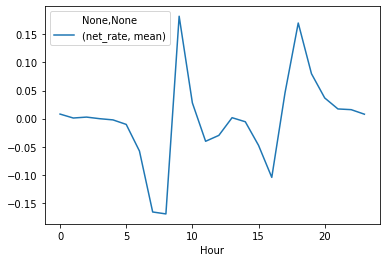

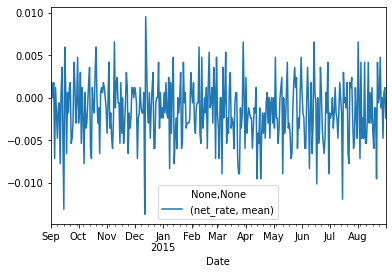

In [26]:
trip_data_agg.groupby(['Hour']).agg({'net_rate': ['mean']}).plot();
trip_data_agg.groupby(['Date']).agg({'net_rate': ['mean']}).plot();

<AxesSubplot:xlabel='Station,Datetime'>

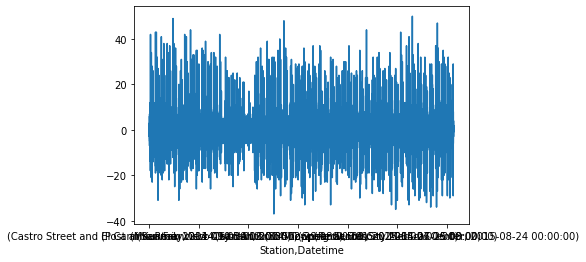

In [34]:
trip_data_agg['net_rate'].plot()

<AxesSubplot:xlabel='Station,Datetime'>

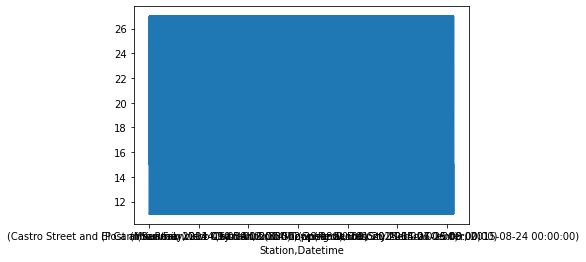

In [35]:
trip_data_agg['Dock_Count'].plot()

<AxesSubplot:xlabel='Station,Datetime'>

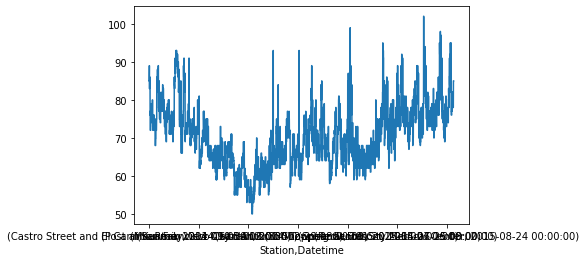

In [36]:
trip_data_agg['Max TemperatureF'].plot()

In [37]:
trip_data_agg['Mean TemperatureF'].plot()

<AxesSubplot:xlabel='Station,Datetime'>

<AxesSubplot:xlabel='Station,Datetime'>

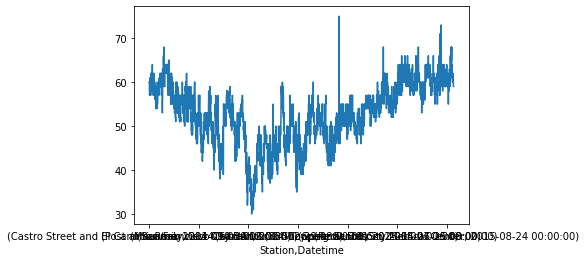

In [38]:
trip_data_agg['Min TemperatureF'].plot()

<AxesSubplot:xlabel='Station,Datetime'>

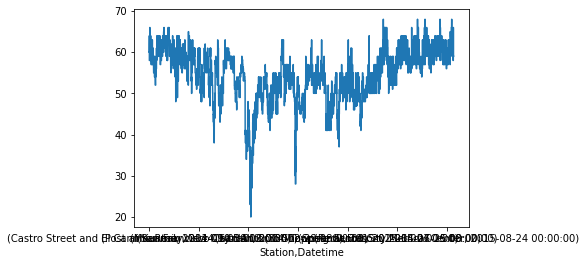

In [39]:
trip_data_agg['Max Dew PointF'].plot()

<AxesSubplot:xlabel='Station,Datetime'>

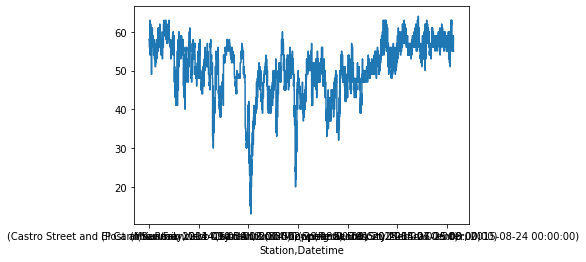

In [40]:
trip_data_agg['MeanDew PointF'].plot()

In [41]:
trip_data_agg['Min DewpointF'].plot()

<AxesSubplot:xlabel='Station,Datetime'>

<AxesSubplot:xlabel='Station,Datetime'>

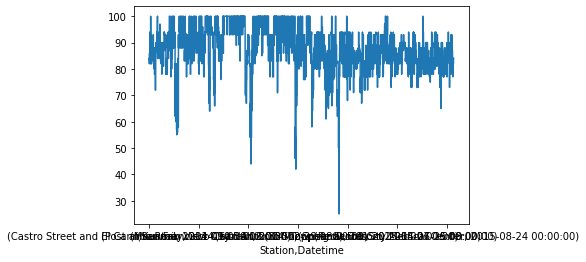

In [42]:
trip_data_agg['Max Humidity'].plot()

<AxesSubplot:xlabel='Station,Datetime'>

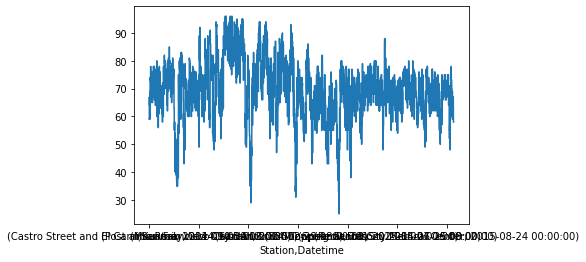

In [43]:
trip_data_agg['Mean Humidity'].plot()

<AxesSubplot:xlabel='Station,Datetime'>

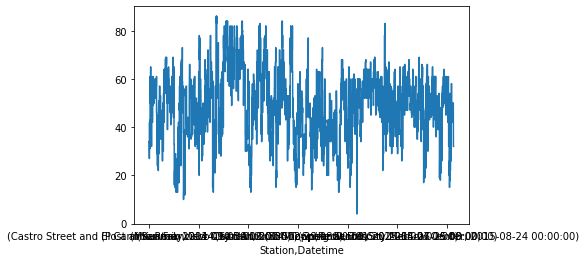

In [44]:
trip_data_agg['Min Humidity'].plot()

In [45]:
trip_data_agg['Max Sea Level PressureIn'].plot()

<AxesSubplot:xlabel='Station,Datetime'>

<AxesSubplot:xlabel='Station,Datetime'>

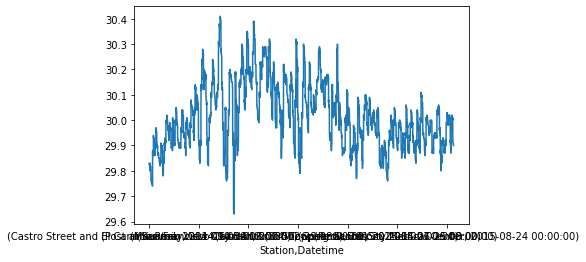

In [46]:
trip_data_agg['Mean Sea Level PressureIn'].plot()

<AxesSubplot:xlabel='Station,Datetime'>

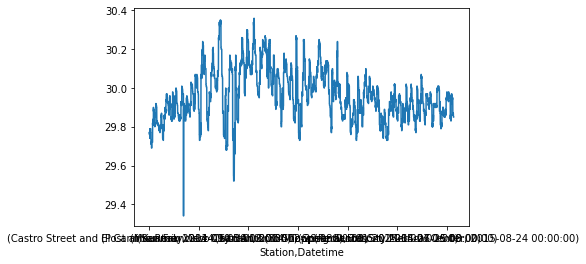

In [47]:
trip_data_agg['Min Sea Level PressureIn'].plot()

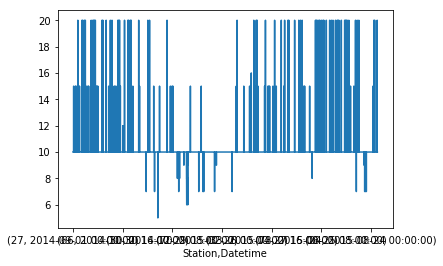

In [47]:
trip_data_agg['Max VisibilityMiles'].plot()

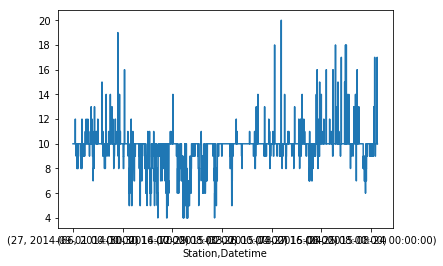

In [48]:
trip_data_agg['Mean VisibilityMiles'].plot()

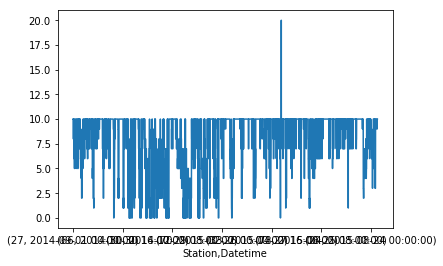

In [49]:
trip_data_agg['Min VisibilityMiles'].plot()

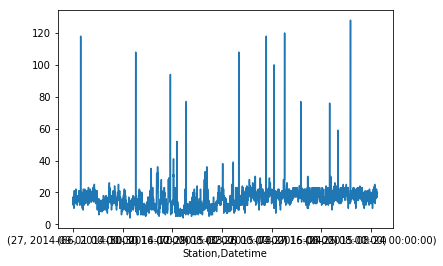

In [50]:
trip_data_agg['Max Wind SpeedMPH'].plot()

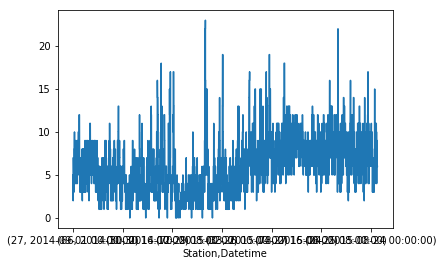

In [51]:
trip_data_agg['Mean Wind SpeedMPH'].plot()

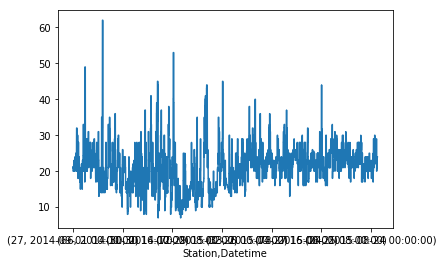

In [52]:
trip_data_agg['Max Gust SpeedMPH'].plot()

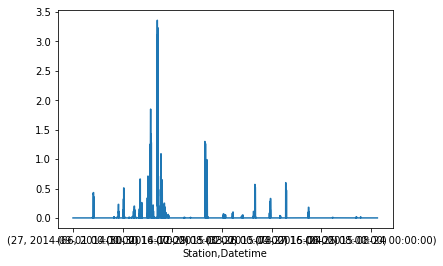

In [53]:
trip_data_agg['PrecipitationIn'].plot()

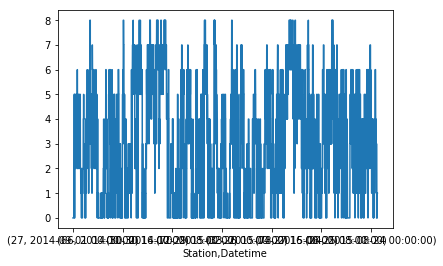

In [54]:
trip_data_agg['CloudCover'].plot()

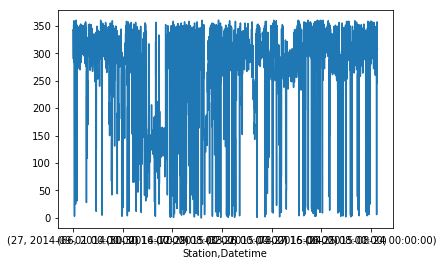

In [56]:
trip_data_agg['WindDirDegrees'].plot()

## Feature Enginnering


In [87]:
# определяем тип покупателя
trip_data = trip_data.join(pd.get_dummies(trip_data['Subscriber_Type']))
trip_data.drop(['Subscriber_Type'], inplace=True, axis=1)

## Temporal Features

In [88]:
# Определяем время дня
trip_data_agg['Is_night'] = trip_data_agg['Hour'].apply(lambda h: 1 if h < 5 or h > 20 else 0)

In [89]:
# Определяем день недели
trip_data_agg['Day_of_week'] = trip_data_agg['Date'].apply(lambda dt: dt.weekday())

<AxesSubplot:xlabel='Day_of_week'>

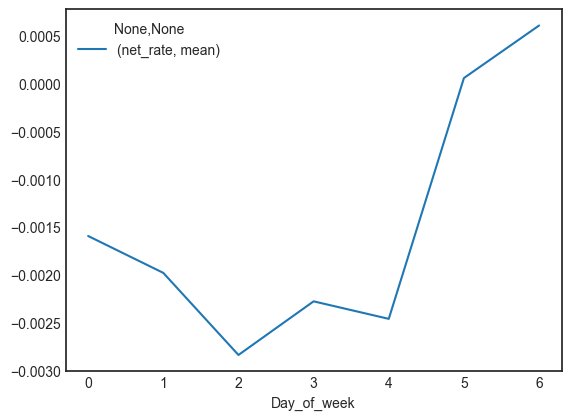

In [90]:
trip_data_agg.groupby(['Day_of_week']).agg({'net_rate': ['mean']}).plot()

In [91]:
# Рабочий или выходной
trip_data_agg['Is_weekday'] = trip_data_agg['Day_of_week']\
        .apply(lambda s: 0 if s in [5, 6] else 1)

In [92]:
# Сизоны: зима (0), осень (1), лето (2), осень (3)
trip_data_agg['Season'] = trip_data_agg['Date'].apply(lambda dt: (dt.month%12 + 3)//3-1)

<AxesSubplot:xlabel='Season'>

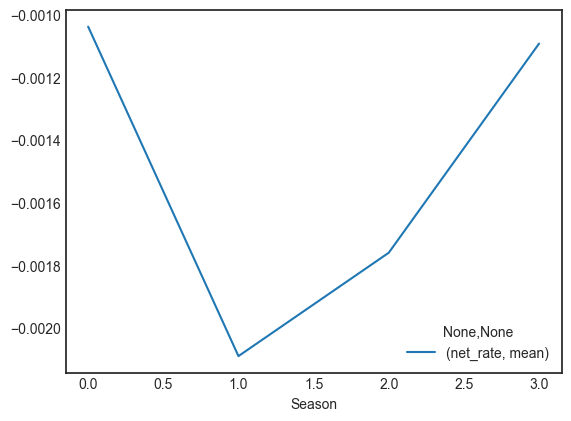

In [93]:
trip_data_agg.groupby(['Season']).agg({'net_rate': ['mean']}).plot()

### Lagged Features

Пользователи деляться на покупателей (разовых) и имеющих подписку. Сделаем расчет фичей по каждому из типов пользователей, их поведени. и тд.

In [94]:
#trip_data

In [95]:
# покупатели
end_trip_data = trip_data.groupby(['End_Station'])\
              .resample('H', on='End_Date')\
              .sum()\
              .reindex(idx, fill_value=0)\
              .drop(['Trip_ID', ], axis=1)

# пользователи с подпиской
start_trip_data = trip_data.groupby(['Start_Station'])\
              .resample('H', on='Start_Date')\
              .sum()\
              .reindex(idx, fill_value=0)\
              .drop(['Trip_ID', ], axis=1)

# общий набор
trip_data_agg = trip_data_agg.join(end_trip_data)\
                             .join(start_trip_data, lsuffix='_end', rsuffix='_start')
    
# trip_data_agg.eval('net_customers=Customer_end+Customer_start', inplace=True)
# trip_data_agg.eval('net_subscribers=Subscriber_end+Subscriber_start', inplace=True)

# trip_data_agg.drop(['Customer_end', 'Subscriber_end', 
#                     'Customer_start', 'Subscriber_start'], inplace=True, axis=1)

#trip_data_agg.drop('Inst_date', axis =1, inplace=True)
trip_data_agg = trip_data_agg.sample(frac=0.1)

In [96]:
# Net rate за преведующий час
trip_data_agg['net_rate_previous_hour'] = \
        trip_data_agg.groupby(['Station', 'Date'])['net_rate']\
                .shift(1).fillna(0)

# # Net покупателей без подписки за преведующий час
# trip_data_agg['net_customers_previous_hour'] = \
#         trip_data_agg.groupby(['Station', 'Date'])['net_customers']\
#                 .shift(1).fillna(0)

# # Net покупателей с подпиской за преведующий час
# trip_data_agg['net_subscribers_previous_hour'] = \
#         trip_data_agg.groupby(['Station', 'Date'])['net_subscribers']\
#                 .shift(1).fillna(0)
        
# trip_data_agg.drop(['net_customers',  'net_subscribers'], inplace=True, axis=1)
trip_data_agg

Date    Zip  \
Station                                 Datetime                                
2nd at Townsend                         2015-03-08 14:00:00 2015-03-08  94107   
Santa Clara at Almaden                  2015-06-01 02:00:00 2015-06-01  95113   
St James Park                           2014-12-29 09:00:00 2014-12-29  95113   
San Francisco Caltrain 2 (330 Townsend) 2014-09-29 19:00:00 2014-09-29  94107   
SJSU 4th at San Carlos                  2014-10-17 23:00:00 2014-10-17  95113   
...                                                                ...    ...   
Post at Kearney                         2014-12-11 01:00:00 2014-12-11  94107   
Civic Center BART (7th at Market)       2015-03-24 12:00:00 2015-03-24  94107   
Redwood City Caltrain Station           2015-05-18 19:00:00 2015-05-18  94063   
San Jose City Hall                      2015-05-16 01:00:00 2015-05-16  95113   
Redwood City Medical Center             2014-10-06 16:00:00 2014-10-06  94063   

                                                             Hour  net_rate  \
Station                                 Datetime                              
2nd at Townsend                         2015-03-08 14:00:00    14         1   
Santa Clara at Almaden                  2015-06-01 02:00:00     2         0   
St James Park                           2014-12-29 09:00:00     9         1   
San Francisco Caltrain 2 (330 Townsend) 2014-09-29 19:00:00    19        -5   
SJSU 4th at San Carlos                  2014-10-17 23:00:00    23         0   
...                                                           ...       ...   
Post at Kearney                         2014-12-11 01:00:00     1         0   
Civic Center BART (7th at Market)       2015-03-24 12:00:00    12         0   
Redwood City Caltrain Station           2015-05-18 19:00:00    19         0   
San Jose City Hall                      2015-05-16 01:00:00     1         0   
Redwood City Medical Center             2014-10-06 16:00:00    16         0   

                                                             Station_id  \
Station                                 Datetime                          
2nd at Townsend                         2015-03-08 14:00:00          61   
Santa Clara at Almaden                  2015-06-01 02:00:00           4   
St James Park                           2014-12-29 09:00:00          13   
San Francisco Caltrain 2 (330 Townsend) 2014-09-29 19:00:00          69   
SJSU 4th at San Carlos                  2014-10-17 23:00:00          12   
...                                                                 ...   
Post at Kearney                         2014-12-11 01:00:00          47   
Civic Center BART (7th at Market)       2015-03-24 12:00:00          72   
Redwood City Caltrain Station           2015-05-18 19:00:00          22   
San Jose City Hall                      2015-05-16 01:00:00          10   
Redwood City Medical Center             2014-10-06 16:00:00          26   

                                                             Dock_Count  \
Station                                 Datetime                          
2nd at Townsend                         2015-03-08 14:00:00          27   
Santa Clara at Almaden                  2015-06-01 02:00:00          11   
St James Park                           2014-12-29 09:00:00          15   
San Francisco Caltrain 2 (330 Townsend) 2014-09-29 19:00:00          23   
SJSU 4th at San Carlos                  2014-10-17 23:00:00          19   
...                                                                 ...   
Post at Kearney                         2014-12-11 01:00:00          19   
Civic Center BART (7th at Market)       2015-03-24 12:00:00          23   
Redwood City Caltrain Station           2015-05-18 19:00:00          25   
San Jose City Hall                      2015-05-16 01:00:00          15   
Redwood City Medical Center             2014-10-06 16:00:00          15   

                                

### Cyclic Ordinal Features

In [ ]:
#https://datascience.stackexchange.com/questions/5990/what-is-a-good-way-to-transform-cyclic-ordinal-attributes

In [97]:
# Час в циклическую фичу
partial_sine = partial(f_sine, T=23)
partial_cosine = partial(f_cosine, T=23)

trip_data_agg['Hour_sine'] = trip_data_agg['Hour'].apply(partial_sine)
trip_data_agg['Hour_cosine'] = trip_data_agg['Hour'].apply(partial_cosine)

# День недели в циклическую фичу
partial_sine = partial(f_sine, T=6)
partial_cosine = partial(f_cosine, T=6)

trip_data_agg['Day_of_week_sine'] = trip_data_agg['Day_of_week'].apply(partial_sine)
trip_data_agg['Day_of_week_cosine'] = trip_data_agg['Day_of_week'].apply(partial_cosine)

# Сизон в циклическую фичу
partial_sine = partial(f_sine, T=3)
partial_cosine = partial(f_cosine, T=3)

trip_data_agg['Season_sine'] = trip_data_agg['Season'].apply(partial_sine)
trip_data_agg['Season_cosine'] = trip_data_agg['Season'].apply(partial_cosine)

### One-hot Encoding of Categorical Features

In [98]:
# OHE Events
trip_data_agg = trip_data_agg.join(pd.get_dummies(trip_data_agg['Events']))

# OHE Station IDs
trip_data_agg.reset_index(inplace=True)

trip_data_agg = trip_data_agg.join(pd.get_dummies(trip_data_agg['Station'], prefix='Station'))

# OHE Zip code
trip_data_agg = trip_data_agg.join(pd.get_dummies(trip_data_agg['Zip'], prefix='Zip'))


In [99]:
trip_data_agg.drop(['Events',  'Station', 'Zip','Hour', 
                    'Day_of_week', 'Season', 'Datetime', 'Date'], 
                   inplace=True, axis=1)

In [100]:
# SOURCE: https://www.kaggle.com/mburakergenc/predictions-with-xgboost-and-linear-regression
# Check any number of columns with NaN
print(trip_data_agg.isnull().any().sum(), ' / ', len(trip_data_agg.columns))

# Check any number of data points with NaN
print(trip_data_agg.isnull().any(axis=1).sum(), ' / ', len(trip_data_agg))

0  /  118
0  /  61320


In [101]:
feature_names = [# Engineered features
                 'Hour_cosine',
                 'Hour_sine',
                 'Day_of_week_cosine',
                 'Day_of_week_sine',
                 'Is_weekday',
                 'Is_night',
                 # Seasonal-base engineered features
                 'Season_cosine',
                 'Season_sine',
                 # Net-rate based egineered features
                 'net_rate_previous_hour',
                 #'net_customers_previous_hour',
                 #'net_subscribers_previous_hour',
                 # Weather-based features
                 'Dock_Count',
                 'Fog',
                 'Fog-Rain',
                 'Clear',
                 'Rain',
                 'Rain-Thunderstorm',
                 'CloudCover',
                 'PrecipitationIn',
                 'WindDirDegrees',
                 # Maximum-based weather features
                 'Max Dew PointF',
                 'Max Gust SpeedMPH',
                 'Max Humidity',
                 'Max Sea Level PressureIn',
                 'Max TemperatureF',
                 'Max VisibilityMiles',
                 'Max Wind SpeedMPH',
                 # Mean-based weather features
                 'Mean Humidity',
                 'Mean Sea Level PressureIn',
                 'Mean TemperatureF',
                 'Mean VisibilityMiles',
                 'Mean Wind SpeedMPH',
                 'MeanDew PointF',
                 # Minimum-based wheather features
                 'Min DewpointF',
                 'Min Humidity',
                 'Min Sea Level PressureIn',
                 'Min TemperatureF',
                 'Min VisibilityMiles',
                 # Zipcode-based features
                 'Zip_94041',
                 'Zip_94063',
                 'Zip_94107',
                 'Zip_94301',
                 'Zip_95113',
]

target_name='net_rate'

In [102]:
# Stratified K-Fold CV
k_fold = 3

outer_kfold_cv = KFold(n_splits=k_fold, random_state=seed)
inner_kfold_cv = KFold(n_splits=k_fold-1, random_state=seed)

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.


In [103]:
X = trip_data_agg[feature_names]
y = trip_data_agg[target_name]

In [104]:
# Разделение на train / test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20,
                                                    random_state=seed)

In [105]:
print('Train data rows = %d, columns = %d' % (X_train.shape[0], X_train.shape[1]))
print('Test data rows = %d, columns = %d' % (X_test.shape[0], X_test.shape[1]))

Train data rows = 49056, columns = 41
Test data rows = 12264, columns = 41


### Feature selection

Используемые методы

- Поиск пропущеных
- Поиск маловариативных (не повторяющихся) значений
- Коллиниарность
- Значимость = 0
- Малая значимость

In [106]:
# numpy and pandas for data manipulation
import pandas as pd
import numpy as np

# model used for feature importances
import lightgbm as lgb

# utility for early stopping with a validation set
from sklearn.model_selection import train_test_split

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# memory management
import gc

# utilities
from itertools import chain

class FeatureSelector():
    """
    Class for performing feature selection for machine learning or data preprocessing.
    
    Implements five different methods to identify features for removal 
    
        1. Find columns with a missing percentage greater than a specified threshold
        2. Find columns with a single unique value
        3. Find collinear variables with a correlation greater than a specified correlation coefficient
        4. Find features with 0.0 feature importance from a gradient boosting machine (gbm)
        5. Find low importance features that do not contribute to a specified cumulative feature importance from the gbm
        
    Parameters
    --------
        data : dataframe
            A dataset with observations in the rows and features in the columns

        labels : array or series, default = None
            Array of labels for training the machine learning model to find feature importances. These can be either binary labels
            (if task is 'classification') or continuous targets (if task is 'regression').
            If no labels are provided, then the feature importance based methods are not available.
        
    Attributes
    --------
    
    ops : dict
        Dictionary of operations run and features identified for removal
        
    missing_stats : dataframe
        The fraction of missing values for all features
    
    record_missing : dataframe
        The fraction of missing values for features with missing fraction above threshold
        
    unique_stats : dataframe
        Number of unique values for all features
    
    record_single_unique : dataframe
        Records the features that have a single unique value
        
    corr_matrix : dataframe
        All correlations between all features in the data
    
    record_collinear : dataframe
        Records the pairs of collinear variables with a correlation coefficient above the threshold
        
    feature_importances : dataframe
        All feature importances from the gradient boosting machine
    
    record_zero_importance : dataframe
        Records the zero importance features in the data according to the gbm
    
    record_low_importance : dataframe
        Records the lowest importance features not needed to reach the threshold of cumulative importance according to the gbm
    
    
    Notes
    --------
    
        - All 5 operations can be run with the `identify_all` method.
        - If using feature importances, one-hot encoding is used for categorical variables which creates new columns
    
    """
    
    def __init__(self, data, labels=None):
        
        # Dataset and optional training labels
        self.data = data
        self.labels = labels

        if labels is None:
            print('No labels provided. Feature importance based methods are not available.')
        
        self.base_features = list(data.columns)
        self.one_hot_features = None
        
        # Dataframes recording information about features to remove
        self.record_missing = None
        self.record_single_unique = None
        self.record_collinear = None
        self.record_zero_importance = None
        self.record_low_importance = None
        
        self.missing_stats = None
        self.unique_stats = None
        self.corr_matrix = None
        self.feature_importances = None
        
        # Dictionary to hold removal operations
        self.ops = {}
        
        self.one_hot_correlated = False
        
    def identify_missing(self, missing_threshold):
        """Find the features with a fraction of missing values above `missing_threshold`"""
        
        self.missing_threshold = missing_threshold

        # Calculate the fraction of missing in each column 
        missing_series = self.data.isnull().sum() / self.data.shape[0]
        self.missing_stats = pd.DataFrame(missing_series).rename(columns = {'index': 'feature', 0: 'missing_fraction'})

        # Sort with highest number of missing values on top
        self.missing_stats = self.missing_stats.sort_values('missing_fraction', ascending = False)

        # Find the columns with a missing percentage above the threshold
        record_missing = pd.DataFrame(missing_series[missing_series > missing_threshold]).reset_index().rename(columns = 
                                                                                                               {'index': 'feature', 
                                                                                                                0: 'missing_fraction'})

        to_drop = list(record_missing['feature'])

        self.record_missing = record_missing
        self.ops['missing'] = to_drop
        
        print('%d features with greater than %0.2f missing values.\n' % (len(self.ops['missing']), self.missing_threshold))
        
    def identify_single_unique(self):
        """Finds features with only a single unique value. NaNs do not count as a unique value. """

        # Calculate the unique counts in each column
        unique_counts = self.data.nunique()
        self.unique_stats = pd.DataFrame(unique_counts).rename(columns = {'index': 'feature', 0: 'nunique'})
        self.unique_stats = self.unique_stats.sort_values('nunique', ascending = True)
        
        # Find the columns with only one unique count
        record_single_unique = pd.DataFrame(unique_counts[unique_counts == 1]).reset_index().rename(columns = {'index': 'feature', 
                                                                                                                0: 'nunique'})

        to_drop = list(record_single_unique['feature'])
    
        self.record_single_unique = record_single_unique
        self.ops['single_unique'] = to_drop
        
        print('%d features with a single unique value.\n' % len(self.ops['single_unique']))
    
    def identify_collinear(self, correlation_threshold, one_hot=False):
        """
        Finds collinear features based on the correlation coefficient between features. 
        For each pair of features with a correlation coefficient greather than `correlation_threshold`,
        only one of the pair is identified for removal. 

        Using code adapted from: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
        
        Parameters
        --------

        correlation_threshold : float between 0 and 1
            Value of the Pearson correlation cofficient for identifying correlation features

        one_hot : boolean, default = False
            Whether to one-hot encode the features before calculating the correlation coefficients

        """
        
        self.correlation_threshold = correlation_threshold
        self.one_hot_correlated = one_hot
        
         # Calculate the correlations between every column
        if one_hot:
            
            # One hot encoding
            features = pd.get_dummies(self.data)
            self.one_hot_features = [column for column in features.columns if column not in self.base_features]

            # Add one hot encoded data to original data
            self.data_all = pd.concat([features[self.one_hot_features], self.data], axis = 1)
            
            corr_matrix = pd.get_dummies(features).corr()

        else:
            corr_matrix = self.data.corr()
        
        self.corr_matrix = corr_matrix
    
        # Extract the upper triangle of the correlation matrix
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
        
        # Select the features with correlations above the threshold
        # Need to use the absolute value
        to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold)]

        # Dataframe to hold correlated pairs
        record_collinear = pd.DataFrame(columns = ['drop_feature', 'corr_feature', 'corr_value'])

        # Iterate through the columns to drop to record pairs of correlated features
        for column in to_drop:

            # Find the correlated features
            corr_features = list(upper.index[upper[column].abs() > correlation_threshold])

            # Find the correlated values
            corr_values = list(upper[column][upper[column].abs() > correlation_threshold])
            drop_features = [column for _ in range(len(corr_features))]    

            # Record the information (need a temp df for now)
            temp_df = pd.DataFrame.from_dict({'drop_feature': drop_features,
                                             'corr_feature': corr_features,
                                             'corr_value': corr_values})

            # Add to dataframe
            record_collinear = record_collinear.append(temp_df, ignore_index = True)

        self.record_collinear = record_collinear
        self.ops['collinear'] = to_drop
        
        print('%d features with a correlation magnitude greater than %0.2f.\n' % (len(self.ops['collinear']), self.correlation_threshold))

    def identify_zero_importance(self, task, eval_metric=None, 
                                 n_iterations=10, early_stopping = False):
        """
        
        Identify the features with zero importance according to a gradient boosting machine.
        The gbm can be trained with early stopping using a validation set to prevent overfitting. 
        The feature importances are averaged over `n_iterations` to reduce variance. 
        
        Uses the LightGBM implementation (http://lightgbm.readthedocs.io/en/latest/index.html)

        Parameters 
        --------

        eval_metric : string
            Evaluation metric to use for the gradient boosting machine for early stopping. Must be
            provided if `early_stopping` is True

        task : string
            The machine learning task, either 'classification' or 'regression'

        n_iterations : int, default = 10
            Number of iterations to train the gradient boosting machine
            
        early_stopping : boolean, default = True
            Whether or not to use early stopping with a validation set when training
        
        
        Notes
        --------
        
        - Features are one-hot encoded to handle the categorical variables before training.
        - The gbm is not optimized for any particular task and might need some hyperparameter tuning
        - Feature importances, including zero importance features, can change across runs

        """

        if early_stopping and eval_metric is None:
            raise ValueError("""eval metric must be provided with early stopping. Examples include "auc" for classification or
                             "l2" for regression.""")
            
        if self.labels is None:
            raise ValueError("No training labels provided.")
        
        # One hot encoding
        features = pd.get_dummies(self.data)
        self.one_hot_features = [column for column in features.columns if column not in self.base_features]

        # Add one hot encoded data to original data
        self.data_all = pd.concat([features[self.one_hot_features], self.data], axis = 1)

        # Extract feature names
        feature_names = list(features.columns)

        # Convert to np array
        features = np.array(features)
        labels = np.array(self.labels).reshape((-1, ))

        # Empty array for feature importances
        feature_importance_values = np.zeros(len(feature_names))
        
        print('Training Gradient Boosting Model\n')
        
        # Iterate through each fold
        for _ in range(n_iterations):

            if task == 'classification':
                model = lgb.LGBMClassifier(n_estimators=1000, learning_rate = 0.05, verbose = -1)

            elif task == 'regression':
                model = lgb.LGBMRegressor(n_estimators=1000, learning_rate = 0.05, verbose = -1)

            else:
                raise ValueError('Task must be either "classification" or "regression"')
                
            # If training using early stopping need a validation set
            if early_stopping:
                
                print(labels)
                
                if len(np.unique(labels)) > 1:
                    
                    train_features, valid_features, train_labels, valid_labels = train_test_split(features, labels, 
                                                                                                  test_size = 0.3)
                                                                                                  #, stratify=labels)

                    # Train the model with early stopping
                    model.fit(train_features, train_labels, eval_metric = eval_metric,
                              eval_set = [(valid_features, valid_labels)],
                              early_stopping_rounds = 100, verbose = -1)

                    # Clean up memory
                    gc.enable()
                    del train_features, train_labels, valid_features, valid_labels
                    gc.collect()
                else:pass  
                
            else:
                model.fit(features, labels)

            # Record the feature importances
            feature_importance_values += model.feature_importances_ / n_iterations

        feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

        # Sort features according to importance
        feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index(drop = True)

        # Normalize the feature importances to add up to one
        feature_importances['normalized_importance'] = feature_importances['importance'] / feature_importances['importance'].sum()
        feature_importances['cumulative_importance'] = np.cumsum(feature_importances['normalized_importance'])

        # Extract the features with zero importance
        record_zero_importance = feature_importances[feature_importances['importance'] == 0.0]
        
        to_drop = list(record_zero_importance['feature'])

        self.feature_importances = feature_importances
        self.record_zero_importance = record_zero_importance
        self.ops['zero_importance'] = to_drop
        
        print('\n%d features with zero importance after one-hot encoding.\n' % len(self.ops['zero_importance']))
    
    def identify_low_importance(self, cumulative_importance):
        """
        Finds the lowest importance features not needed to account for `cumulative_importance` fraction
        of the total feature importance from the gradient boosting machine. As an example, if cumulative
        importance is set to 0.95, this will retain only the most important features needed to 
        reach 95% of the total feature importance. The identified features are those not needed.

        Parameters
        --------
        cumulative_importance : float between 0 and 1
            The fraction of cumulative importance to account for 

        """

        self.cumulative_importance = cumulative_importance
        
        # The feature importances need to be calculated before running
        if self.feature_importances is None:
            raise NotImplementedError("""Feature importances have not yet been determined. 
                                         Call the `identify_zero_importance` method first.""")
            
        # Make sure most important features are on top
        self.feature_importances = self.feature_importances.sort_values('cumulative_importance')

        # Identify the features not needed to reach the cumulative_importance
        record_low_importance = self.feature_importances[self.feature_importances['cumulative_importance'] > cumulative_importance]

        to_drop = list(record_low_importance['feature'])

        self.record_low_importance = record_low_importance
        self.ops['low_importance'] = to_drop
    
            #len(self.record_low_importance), self.cumulative_importance))
        print('%d features do not contribute to cumulative importance of %0.2f.\n' % (len(self.ops['low_importance']),
                                                                                               self.cumulative_importance))
        
    def identify_all(self, selection_params):
        """
        Use all five of the methods to identify features to remove.
        
        Parameters
        --------
            
        selection_params : dict
           Parameters to use in the five feature selection methhods.
           Params must contain the keys ['missing_threshold', 'correlation_threshold', 'eval_metric', 'task', 'cumulative_importance']
        
        """
        
        # Check for all required parameters
        for param in ['missing_threshold', 'correlation_threshold', 'eval_metric', 'task', 'cumulative_importance']:
            if param not in selection_params.keys():
                raise ValueError('%s is a required parameter for this method.' % param)
        
        # Implement each of the five methods
        self.identify_missing(selection_params['missing_threshold'])
        self.identify_single_unique()
        self.identify_collinear(selection_params['correlation_threshold'])
        self.identify_zero_importance(task = selection_params['task'], eval_metric = selection_params['eval_metric'])
        self.identify_low_importance(selection_params['cumulative_importance'])
        
        # Find the number of features identified to drop
        self.all_identified = set(list(chain(*list(self.ops.values()))))
        self.n_identified = len(self.all_identified)
        
        print('%d total features out of %d identified for removal after one-hot encoding.\n' % (self.n_identified, 
                                                                                                  self.data_all.shape[1]))
        
    def check_removal(self, keep_one_hot=True):
        
        """Check the identified features before removal. Returns a list of the unique features identified."""
        
        self.all_identified = set(list(chain(*list(self.ops.values()))))
        print('Total of %d features identified for removal' % len(self.all_identified))
        
        if not keep_one_hot:
            if self.one_hot_features is None:
                print('Data has not been one-hot encoded')
            else:
                one_hot_to_remove = [x for x in self.one_hot_features if x not in self.all_identified]
                print('%d additional one-hot features can be removed' % len(one_hot_to_remove))
        
        return list(self.all_identified)
        
    
    def remove(self, methods, keep_one_hot = True):
        """
        Remove the features from the data according to the specified methods.
        
        Parameters
        --------
            methods : 'all' or list of methods
                If methods == 'all', any methods that have identified features will be used
                Otherwise, only the specified methods will be used.
                Can be one of ['missing', 'single_unique', 'collinear', 'zero_importance', 'low_importance']
            keep_one_hot : boolean, default = True
                Whether or not to keep one-hot encoded features
                
        Return
        --------
            data : dataframe
                Dataframe with identified features removed
                
        
        Notes 
        --------
            - If feature importances are used, the one-hot encoded columns will be added to the data (and then may be removed)
            - Check the features that will be removed before transforming data!
        
        """
        
        
        features_to_drop = []
      
        if methods == 'all':
            
            # Need to use one-hot encoded data as well
            data = self.data_all
                                          
            print('{} methods have been run\n'.format(list(self.ops.keys())))
            
            # Find the unique features to drop
            features_to_drop = set(list(chain(*list(self.ops.values()))))
            
        else:
            # Need to use one-hot encoded data as well
            if 'zero_importance' in methods or 'low_importance' in methods or self.one_hot_correlated:
                data = self.data_all
                
            else:
                data = self.data
                
            # Iterate through the specified methods
            for method in methods:
                
                # Check to make sure the method has been run
                if method not in self.ops.keys():
                    raise NotImplementedError('%s method has not been run' % method)
                    
                # Append the features identified for removal
                else:
                    features_to_drop.append(self.ops[method])
        
            # Find the unique features to drop
            features_to_drop = set(list(chain(*features_to_drop)))
            
        features_to_drop = list(features_to_drop)
            
        if not keep_one_hot:
            
            if self.one_hot_features is None:
                print('Data has not been one-hot encoded')
            else:
                             
                features_to_drop = list(set(features_to_drop) | set(self.one_hot_features))
       
        # Remove the features and return the data
        data = data.drop(columns = features_to_drop)
        self.removed_features = features_to_drop
        
        if not keep_one_hot:
        	print('Removed %d features including one-hot features.' % len(features_to_drop))
        else:
        	print('Removed %d features.' % len(features_to_drop))
        
        return data
    
    def plot_missing(self):
        """Histogram of missing fraction in each feature"""
        if self.record_missing is None:
            raise NotImplementedError("Missing values have not been calculated. Run `identify_missing`")
        
        self.reset_plot()
        
        # Histogram of missing values
        plt.style.use('seaborn-white')
        plt.figure(figsize = (7, 5))
        plt.hist(self.missing_stats['missing_fraction'], bins = np.linspace(0, 1, 11), edgecolor = 'k', color = 'red', linewidth = 1.5)
        plt.xticks(np.linspace(0, 1, 11));
        plt.xlabel('Missing Fraction', size = 14); plt.ylabel('Count of Features', size = 14); 
        plt.title("Fraction of Missing Values Histogram", size = 16);
        
    
    def plot_unique(self):
        """Histogram of number of unique values in each feature"""
        if self.record_single_unique is None:
            raise NotImplementedError('Unique values have not been calculated. Run `identify_single_unique`')
        
        self.reset_plot()

        # Histogram of number of unique values
        self.unique_stats.plot.hist(edgecolor = 'k', figsize = (7, 5))
        plt.ylabel('Frequency', size = 14); plt.xlabel('Unique Values', size = 14); 
        plt.title('Number of Unique Values Histogram', size = 16);
        
    
    def plot_collinear(self, plot_all = False):
        """
        Heatmap of the correlation values. If plot_all = True plots all the correlations otherwise
        plots only those features that have a correlation above the threshold
        
        Notes
        --------
            - Not all of the plotted correlations are above the threshold because this plots
            all the variables that have been idenfitied as having even one correlation above the threshold
            - The features on the x-axis are those that will be removed. The features on the y-axis
            are the correlated features with those on the x-axis
            
        
        Code adapted from https://seaborn.pydata.org/examples/many_pairwise_correlations.html
        """
        
        if self.record_collinear is None:
            raise NotImplementedError('Collinear features have not been idenfitied. Run `identify_collinear`.')
        
        if plot_all:
        	corr_matrix_plot = self.corr_matrix
        	title = 'All Correlations'
        
        else:
	        # Identify the correlations that were above the threshold
	        # columns (x-axis) are features to drop and rows (y_axis) are correlated pairs
	        corr_matrix_plot = self.corr_matrix.loc[list(set(self.record_collinear['corr_feature'])), 
	                                                list(set(self.record_collinear['drop_feature']))]

	        title = "Correlations Above Threshold"

       
        f, ax = plt.subplots(figsize=(10, 8))
        
        # Diverging colormap
        cmap = sns.diverging_palette(220, 10, as_cmap=True)

        # Draw the heatmap with a color bar
        sns.heatmap(corr_matrix_plot, cmap=cmap, center=0,
                    linewidths=.25, cbar_kws={"shrink": 0.6})

        # Set the ylabels 
        ax.set_yticks([x + 0.5 for x in list(range(corr_matrix_plot.shape[0]))])
        ax.set_yticklabels(list(corr_matrix_plot.index), size = int(160 / corr_matrix_plot.shape[0]));

        # Set the xlabels 
        ax.set_xticks([x + 0.5 for x in list(range(corr_matrix_plot.shape[1]))])
        ax.set_xticklabels(list(corr_matrix_plot.columns), size = int(160 / corr_matrix_plot.shape[1]));
        plt.title(title, size = 14)
        
    def plot_feature_importances(self, plot_n = 15, threshold = None):
        """
        Plots `plot_n` most important features and the cumulative importance of features.
        If `threshold` is provided, prints the number of features needed to reach `threshold` cumulative importance.

        Parameters
        --------
        
        plot_n : int, default = 15
            Number of most important features to plot. Defaults to 15 or the maximum number of features whichever is smaller
        
        threshold : float, between 0 and 1 default = None
            Threshold for printing information about cumulative importances

        """
        
        if self.record_zero_importance is None:
            raise NotImplementedError('Feature importances have not been determined. Run `idenfity_zero_importance`')
            
        # Need to adjust number of features if greater than the features in the data
        if plot_n > self.feature_importances.shape[0]:
            plot_n = self.feature_importances.shape[0] - 1

        self.reset_plot()
        
        # Make a horizontal bar chart of feature importances
        plt.figure(figsize = (10, 6))
        ax = plt.subplot()

        # Need to reverse the index to plot most important on top
        # There might be a more efficient method to accomplish this
        ax.barh(list(reversed(list(self.feature_importances.index[:plot_n]))), 
                self.feature_importances['normalized_importance'][:plot_n], 
                align = 'center', edgecolor = 'k')

        # Set the yticks and labels
        ax.set_yticks(list(reversed(list(self.feature_importances.index[:plot_n]))))
        ax.set_yticklabels(self.feature_importances['feature'][:plot_n], size = 12)

        # Plot labeling
        plt.xlabel('Normalized Importance', size = 16); plt.title('Feature Importances', size = 18)
        plt.show()

        # Cumulative importance plot
        plt.figure(figsize = (6, 4))
        plt.plot(list(range(1, len(self.feature_importances) + 1)), self.feature_importances['cumulative_importance'], 'r-')
        plt.xlabel('Number of Features', size = 14); plt.ylabel('Cumulative Importance', size = 14); 
        plt.title('Cumulative Feature Importance', size = 16);

        if threshold:

            # Index of minimum number of features needed for cumulative importance threshold
            # np.where returns the index so need to add 1 to have correct number
            importance_index = np.min(np.where(self.feature_importances['cumulative_importance'] > threshold))
            plt.vlines(x = importance_index + 1, ymin = 0, ymax = 1, linestyles='--', colors = 'blue')
            plt.show();

            print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))

    def reset_plot(self):
        plt.rcParams = plt.rcParamsDefault


In [107]:
# Пробуем отбор на трейне
fs = FeatureSelector(data = X_train, labels = y_train)

In [108]:
# запуск методов
fs.identify_all(selection_params = {'missing_threshold': 0.5, 
                                    'correlation_threshold': 0.7, 
                                    'task': 'regression', 
                                    'eval_metric': 'l2',
                                    'cumulative_importance': 0.9})

0 features with greater than 0.50 missing values.

0 features with a single unique value.

11 features with a correlation magnitude greater than 0.70.

Training Gradient Boosting Model


1 features with zero importance after one-hot encoding.

19 features do not contribute to cumulative importance of 0.90.

26 total features out of 41 identified for removal after one-hot encoding.



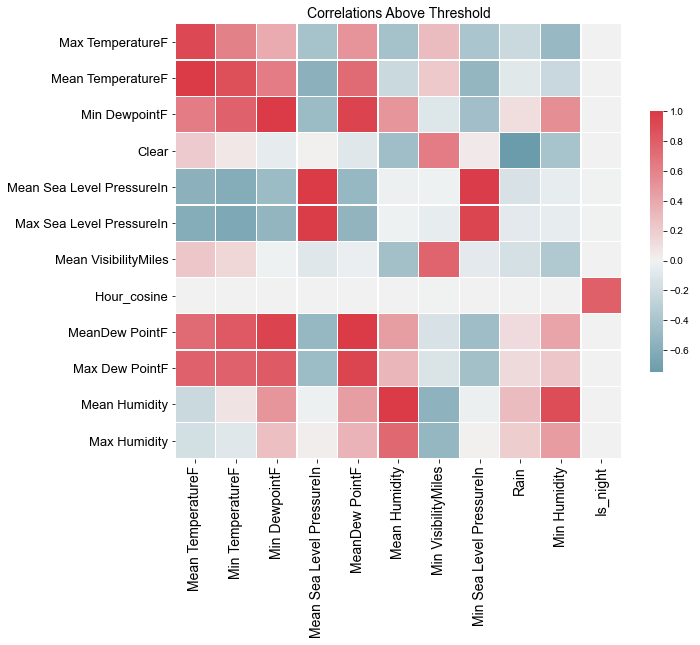

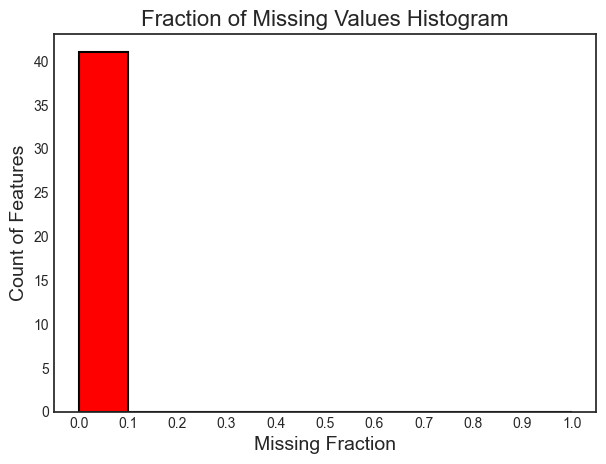

23 features required for 0.90 of cumulative importance


In [53]:
# визуализация результатов
fs.plot_collinear()
fs.plot_missing()
fs.plot_feature_importances(threshold = 0.90, plot_n = 30)

In [109]:
fs.data_all.head()

Hour_cosine  Hour_sine  Day_of_week_cosine  Day_of_week_sine  \
59697     0.682553   0.730836                 1.0      0.000000e+00   
23058     0.460065   0.887885                -0.5      8.660254e-01   
41299    -0.775711   0.631088                 1.0     -2.449294e-16   
16866     0.682553  -0.730836                -0.5      8.660254e-01   
1876      0.460065  -0.887885                -0.5     -8.660254e-01   

       Is_weekday  Is_night  Season_cosine   Season_sine  \
59697           1         1            1.0 -2.449294e-16   
23058           1         1            1.0  0.000000e+00   
41299           0         0            1.0  0.000000e+00   
16866           1         0            1.0  0.000000e+00   
1876            1         0            1.0 -2.449294e-16   

       net_rate_previous_hour  Dock_Count  ...  Min DewpointF  Min Humidity  \
59697                     0.0          15  ...           50.0          59.0   
23058                     0.0          15  ...           46.0          63.0   
41299                     0.0          23  ...           52.0          72.0   
16866                     0.0          19  ...           45.0          64.0   
1876                      0.0          27  ...           54.0          53.0   

       Min Sea Level PressureIn  Min TemperatureF  Min VisibilityMiles  \
59697                     29.91              54.0                  7.0   
23058                     30.10              53.0                  6.0   
41299                     30.26              56.0                  7.0   
16866                     30.12              50.0                  7.0   
1876                      29.90              60.0                 10.0   

       Zip_94041  Zip_94063  Zip_94107  Zip_94301  Zip_95113  
59697          0          0          0          0          1  
23058          0          0          0          0          1  
41299          1          0          0          0          0  
16866          0          0          1          0          0  
1876           0          0          1          0          0  

[5 rows x 41 columns]

In [110]:
data_removed = fs.remove(methods = 'all', keep_one_hot=False)
missing_features = fs.ops['missing']
missing_features[:5]

['missing', 'single_unique', 'collinear', 'zero_importance', 'low_importance'] methods have been run

Removed 26 features including one-hot features.


[]

In [111]:
# обзор пропущенных
print(fs.missing_stats.head(5))

                          missing_fraction
Hour_cosine                            0.0
Max Sea Level PressureIn               0.0
Max VisibilityMiles                    0.0
Max Wind SpeedMPH                      0.0
Mean Humidity                          0.0


In [112]:
# коллиниарные фичи
fs.identify_collinear(correlation_threshold = 0.90)

5 features with a correlation magnitude greater than 0.90.



In [113]:
# получим список всех коллиниарных фичей
collinear_features = fs.ops['collinear']

In [114]:
fs.record_collinear.head(len(feature_names))

drop_feature               corr_feature  corr_value
0  Mean Sea Level PressureIn   Max Sea Level PressureIn    0.981459
1          Mean TemperatureF           Max TemperatureF    0.911664
2             MeanDew PointF             Max Dew PointF    0.934469
3              Min DewpointF             MeanDew PointF    0.949719
4   Min Sea Level PressureIn   Max Sea Level PressureIn    0.935460
5   Min Sea Level PressureIn  Mean Sea Level PressureIn    0.979674

In [115]:
# получим данные о не важных фичах
fs.identify_zero_importance(task = 'regression', 
                            eval_metric = 'l2', 
                            n_iterations = 5, 
                            early_stopping = True)

Training Gradient Boosting Model

[0 0 0 ... 0 0 0]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[239]	valid_0's l2: 2.65961
[0 0 0 ... 0 0 0]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[240]	valid_0's l2: 2.57418
[0 0 0 ... 0 0 0]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[161]	valid_0's l2: 2.43361
[0 0 0 ... 0 0 0]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[70]	valid_0's l2: 2.71091
[0 0 0 ... 0 0 0]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[147]	valid_0's l2: 2.55477

2 features with zero importance after one-hot encoding.



In [116]:
zero_importance_features = fs.ops['zero_importance']

In [117]:
# получим только те фичи, которые дают 95% знаний
print(fs.identify_low_importance(cumulative_importance = 0.95))

16 features do not contribute to cumulative importance of 0.95.

None


In [118]:
# Все значимости
print(fs.feature_importances.head(len(feature_names)))

                      feature  importance  normalized_importance  \
0                   Hour_sine       647.6               0.125943   
1                 Hour_cosine       561.4               0.109179   
2      net_rate_previous_hour       518.4               0.100817   
3                  Dock_Count       433.2               0.084247   
4                   Zip_94107       244.0               0.047452   
5              WindDirDegrees       218.2               0.042435   
6           Max Gust SpeedMPH       193.0               0.037534   
7    Max Sea Level PressureIn       164.6               0.032011   
8            Day_of_week_sine       141.8               0.027577   
9                Min Humidity       141.6               0.027538   
10           Max TemperatureF       137.8               0.026799   
11   Min Sea Level PressureIn       130.2               0.025321   
12              Mean Humidity       125.8               0.024465   
13          Max Wind SpeedMPH       124.2       

In [119]:
fs.identify_single_unique()

0 features with a single unique value.



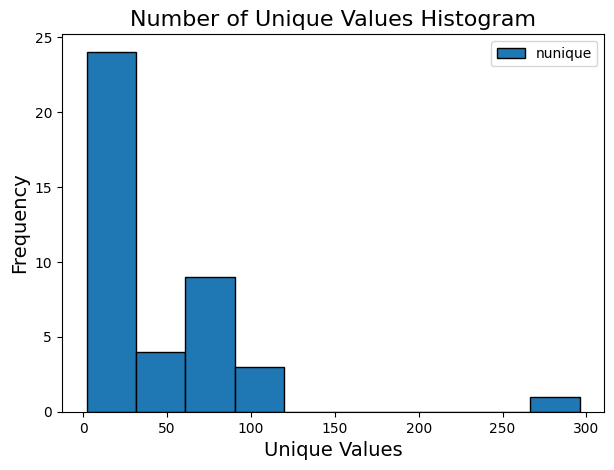

In [77]:
fs.plot_unique()
plt.show()

#### Relief algorithm | Coalition Game Theory

In [88]:
# %%time
# fs = ReliefF(n_features_to_select=len(feature_names))
# fs.fit(X_train.values, y_train.values)

In [89]:
# d = dict(zip(X_train.columns, fs.feature_importances_))
# d_sorted_by_value = OrderedDict(sorted(d.items(), key=lambda x: -x[1]))

# for feature_name, feature_score in d_sorted_by_value.items():
#     print("%-25s\t%s"% (feature_name, feature_score))

In [90]:
# %%time
# fs = TuRF(core_algorithm="ReliefF", n_features_to_select=30, pct=0.5,verbose=True)
# fs.fit(X_train.values, y_train.values, list(X_train.columns))

In [91]:
# d = dict(zip(X_train.columns, fs.feature_importances_))
# d_sorted_by_value = OrderedDict(sorted(d.items(), key=lambda x: -x[1]))

# for feature_name, feature_score in d_sorted_by_value.items():
#     print "%-25s\t%s"% (feature_name, feature_score)

In [92]:
# # Сортируем фичи по уменьшению скора (используем TuRF)
# scoreDict=dict(zip(X_train.columns, fs.feature_importances_))
# scored_features = len(fs.top_features_)
# sorted_names = sorted(scoreDict, key=lambda x: scoreDict[x], reverse=True)

# n = 1

# for k in sorted_names:
#     if n < scored_features +1 :
#         print("%-25s\t%s\t%s" % (str(k), str(scoreDict[k]), str(n)))
#     else:
#         print("%-25s\t%s\t*"% (str(k), str(scoreDict[k])))
#     n += 1

In [93]:
# %%time
# fs = TuRF(core_algorithm="SURF", n_features_to_select=30, pct=0.5,verbose=True)
# fs.fit(X_train.values, y_train.values, headers)

In [94]:
# %%time
# fs = TuRF(core_algorithm="SURFstar", n_features_to_select=30, pct=0.5,verbose=True)
# fs.fit(X_train.values, y_train.values, headers)

In [95]:
# %%time
# fs = TuRF(core_algorithm="SURF", n_features_to_select=30, pct=0.5,verbose=True)
# fs.fit(X_train.values, y_train.values, headers)

In [96]:
# %%time
# fs = TuRF(core_algorithm="MultiSURF", n_features_to_select=30, pct=0.5,verbose=True)
# fs.fit(X_train.values, y_train.values, headers)

In [97]:
# %%time
# fs = TuRF(core_algorithm="MultiSURFstar", n_features_to_select=30, pct=0.5,verbose=True)
# fs.fit(X_train.values, y_train.values, headers)

In [98]:
# print('DONE')

## Regularized linear regressions

- Linear regresssion (no regularization)
- Ridge regression (L2-norm)
- LASSO regression (L1-norm)
- Elasticnet regression (с пенальти L1 и L2)
- Bayesian regression (L2 с Gaussian prior)
-  Least Angle regression (LAR)


### Linear Regression with Lasso regularization (L1 penalty)

In [120]:
alphas_lasso = [1e-6, 1e-5, 0.00005, 0.0001, 0.0005, 0.001, 0.01, 0.03, 0.06, 0.09, 0.1, 0.15] 
lassoCV = LassoCV(alphas=alphas_lasso)

In [121]:
lassoCV.fit(X_train, y_train)

Objective did not converge. You might want to increase the number of iterations. Duality gap: 109.50801116052025, tolerance: 10.732185281826558
Objective did not converge. You might want to increase the number of iterations. Duality gap: 781.787291941233, tolerance: 10.732185281826558
Objective did not converge. You might want to increase the number of iterations. Duality gap: 8032.243062067544, tolerance: 10.732185281826558
Objective did not converge. You might want to increase the number of iterations. Duality gap: 3188.234331300715, tolerance: 10.732185281826558
Objective did not converge. You might want to increase the number of iterations. Duality gap: 10526.011694224217, tolerance: 10.732185281826558
Objective did not converge. You might want to increase the number of iterations. Duality gap: 37779.00432792053, tolerance: 10.732185281826558
Objective did not converge. You might want to increase the number of iterations. Duality gap: 103.88225297855388, tolerance: 11.0283941291883

LassoCV(alphas=[1e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.01, 0.03, 0.06,
                0.09, 0.1, 0.15])

In [122]:
alpha = lassoCV.alpha_
print("Best Lasso alpha:", alpha)

Best Lasso alpha: 0.01


In [123]:
lasso = Lasso(alpha=0.0001)

In [124]:
lasso.fit(X_train, y_train)

Objective did not converge. You might want to increase the number of iterations. Duality gap: 13823.193661549158, tolerance: 13.657885271934218


Lasso(alpha=0.0001)

In [125]:
print("RMSE on Training set :", rmse_cv(lasso, X_train, y_train).mean())
print("RMSE on Test set :", rmse_cv(lasso, X_test, y_test).mean())

Objective did not converge. You might want to increase the number of iterations. Duality gap: 21648.759952877583, tolerance: 8.930810588918806
Objective did not converge. You might want to increase the number of iterations. Duality gap: 913.5532948892796, tolerance: 9.440297428449185
Objective did not converge. You might want to increase the number of iterations. Duality gap: 3658.608556777501, tolerance: 8.944597602739748


RMSE on Training set : 1.668602642994502


Objective did not converge. You might want to increase the number of iterations. Duality gap: 7943.591295832884, tolerance: 2.472385909980425
Objective did not converge. You might want to increase the number of iterations. Duality gap: 6430.350366293793, tolerance: 2.184931849315068


RMSE on Test set : 1.691934892751786


Objective did not converge. You might want to increase the number of iterations. Duality gap: 2946.868116514359, tolerance: 2.3622598336594782


In [126]:
predictions = lasso.predict(X_test)
print(explained_variance_score(predictions, y_test))

# Root Mean Squared Error
print("RMSE: %.3f"
      % math.sqrt(np.mean((lasso.predict(X_test) - y_test) ** 2)))

-911.8965396137979
RMSE: 1.693


In [127]:
scoring = 'neg_mean_squared_error'
kfold = KFold(n_splits=5, random_state=seed)
cv_results = cross_val_score(lasso,
                             X, y,
                             cv=kfold,
                             scoring=scoring)

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
Objective did not converge. You might want to increase the number of iterations. Duality gap: 12737.26575230241, tolerance: 13.865292692025559
Objective did not converge. You might want to increase the number of iterations. Duality gap: 4200.882268979083, tolerance: 13.540869159735804
Objective did not converge. You might want to increase the number of iterations. Duality gap: 16382.623961373785, tolerance: 13.63183170254406
Objective did not converge. You might want to increase the number of iterations. Duality gap: 24243.83132203442, tolerance: 14.028892692025556


In [128]:
print('RMSE: %.3f (%.3f)' % (cv_results.mean(), cv_results.std()))

RMSE: -2.803 (0.148)


In [129]:
pred_train = lasso.predict(X_train)
pred_test  = lasso.predict(X_test)

In [130]:
# Потери 
plt.scatter(pred_train, pred_train - y_train, 
            c = "blue", marker = ".", label = "Training data")
plt.scatter(pred_test, pred_test - y_test, 
            c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with LASSO regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = -15, xmax = 20, color = "red")
plt.show()

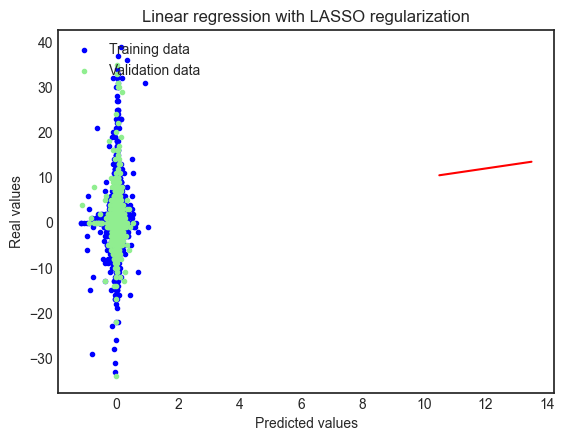

In [131]:
# Предикт
plt.scatter(pred_train, y_train, c = "blue", marker = ".", label = "Training data")
plt.scatter(pred_test, y_test, c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with LASSO regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

LASSO picked 34 features and eliminated the other 7 features


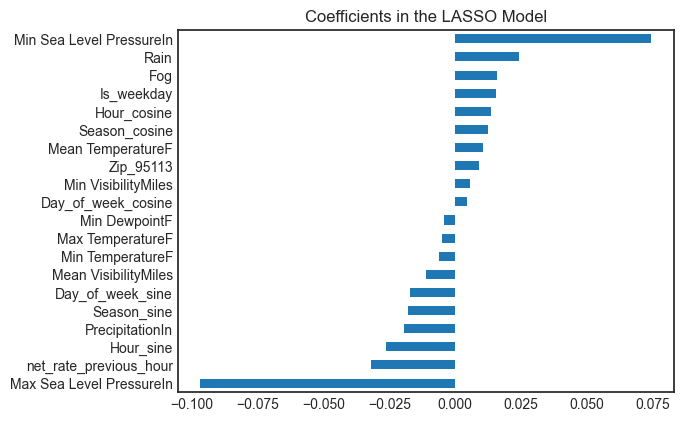

In [132]:
# Важность коэффициентов
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("LASSO picked " + str(sum(coefs != 0)) + \
      " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the LASSO Model")
plt.show()

In [133]:
alphas = [0.05, 0.1, 0.3, 1, 3, 4, 10, 15, 30, 50, 75, 100]

cv_lasso = [rmse_cv(Lasso(alpha=alpha), X_train, y_train).mean() 
            for alpha in alphas
           ]

cv_lasso = pd.Series(np.expm1(cv_lasso), index=alphas)
cv_lasso = pd.Series(cv_lasso, index=alphas)

plt.figure()
cv_lasso.plot(title = "LASSO, Validation")
plt.xlabel('alpha')
plt.ylabel('rmse')
plt.show()
print("\nLASSO optimal regularization parameter alpha has rmse = ")
print(cv_lasso.min())


LASSO optimal regularization parameter alpha has rmse = 
4.301598306808104


### Linear Regression with Ridge regularization (L2 penalty)

In [135]:
# Linear Regression with Ridge regularization 
ridgeCV = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])

In [136]:
ridgeCV.fit(X_train, y_train)

RidgeCV(alphas=array([1.e-02, 3.e-02, 6.e-02, 1.e-01, 3.e-01, 6.e-01, 1.e+00, 3.e+00,
       6.e+00, 1.e+01, 3.e+01, 6.e+01]))

In [137]:
alpha = ridgeCV.alpha_
print("Best alpha :", alpha)

Best alpha : 60.0


In [138]:
ridge = Ridge(alpha=60.0)

In [139]:
ridge.fit(X_train, y_train)

Ridge(alpha=60.0)

In [140]:
print("RMSE on Training set :", rmse_cv(ridge, X_train, y_train).mean())
print("RMSE on Test set :", rmse_cv(ridge, X_test, y_test).mean())

RMSE on Training set : 1.6686170913892227
RMSE on Test set : 1.6918697151510749


In [141]:
predictions = ridge.predict(X_test)
print(explained_variance_score(predictions, y_test))

# Calculate the Root Mean Squared Error
print("RMSE: %.3f"
      % math.sqrt(np.mean((ridge.predict(X_test) - y_test) ** 2)))

-899.4647717571074
RMSE: 1.693


In [142]:
scoring = 'neg_mean_squared_error'
kfold = KFold(n_splits=5, random_state=seed)
cv_results = cross_val_score(ridge,
                             X, y,
                             cv=kfold,
                             scoring=scoring)

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.


In [143]:
print('RMSE: %.3f (%.3f)' % (cv_results.mean(), cv_results.std()))

RMSE: -2.803 (0.148)


In [144]:
pred_train = ridge.predict(X_train)
pred_test  = ridge.predict(X_test)

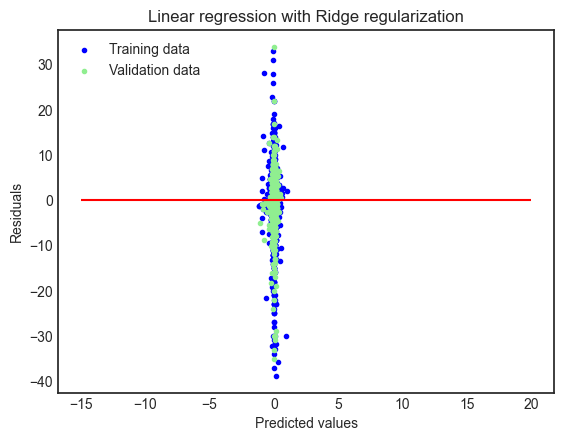

In [145]:
# Потери
plt.scatter(pred_train, pred_train - y_train, 
            c = "blue", marker = ".", label = "Training data")
plt.scatter(pred_test, pred_test - y_test, 
            c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = -15, xmax = 20, color = "red")
plt.show()

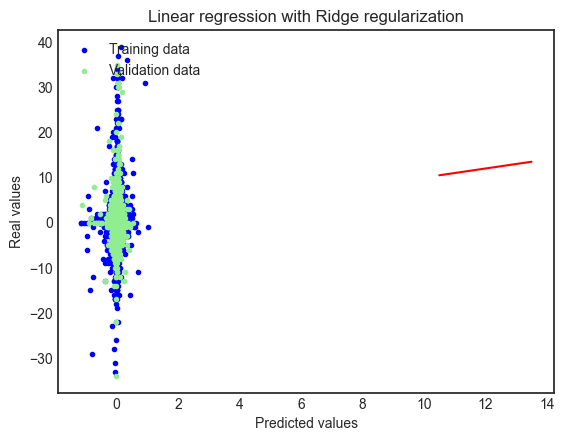

In [146]:
# Предсказание 
plt.scatter(pred_train, y_train, c = "blue", marker = ".", label = "Training data")
plt.scatter(pred_test, y_test, c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

In [147]:
# Важность коэффициентов
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + \
      " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

Ridge picked 41 features and eliminated the other 0 features


### Linear Regression with ElasticNet regularization (L1 and L2 penalty)

In [148]:
elasticNetCV = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)

In [149]:
elasticNetCV.fit(X_train, y_train)

ElasticNetCV(alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03,
                     0.06, 0.1, 0.3, 0.6, 1, 3, 6],
             cv=10, l1_ratio=[0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
             max_iter=50000)

In [150]:
alpha = elasticNetCV.alpha_
ratio = elasticNetCV.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

Best l1_ratio : 0.6
Best alpha : 0.03


In [151]:
elasticNet = ElasticNet(l1_ratio=0.7,alpha=0.0003)

In [152]:
elasticNet.fit(X_train, y_train)

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3203.5201641629974, tolerance: 13.657885271934218


ElasticNet(alpha=0.0003, l1_ratio=0.7)

In [153]:
print("RMSE on Training set :", rmse_cv(elasticNet, X_train, y_train).mean())
print("Test set :", rmse_cv(elasticNet, X_test, y_test).mean())

Objective did not converge. You might want to increase the number of iterations. Duality gap: 10675.791877707896, tolerance: 8.930810588918806


RMSE on Training set : 1.6685662017531475


Objective did not converge. You might want to increase the number of iterations. Duality gap: 5017.315630493005, tolerance: 2.472385909980425
Objective did not converge. You might want to increase the number of iterations. Duality gap: 4349.376943729881, tolerance: 2.184931849315068


Test set : 1.6919091326562785


Objective did not converge. You might want to increase the number of iterations. Duality gap: 944.8842080352297, tolerance: 2.3622598336594782


In [154]:
predictions = elasticNet.predict(X_test)
print(explained_variance_score(predictions, y_test))

# Root Mean Squared Error
print("RMSE: %.3f"
      % math.sqrt(np.mean((elasticNet.predict(X_test) - y_test) ** 2)))

-932.0275636983074
RMSE: 1.693


In [155]:
scoring = 'neg_mean_squared_error'
kfold = KFold(n_splits=5, random_state=seed)
cv_results = cross_val_score(elasticNet,
                             X, y,
                             cv=kfold,
                             scoring=scoring)

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2061.867989080216, tolerance: 13.865292692025559
Objective did not converge. You might want to increase the number of iterations. Duality gap: 3904.2030775439343, tolerance: 13.63183170254406
Objective did not converge. You might want to increase the number of iterations. Duality gap: 531.866733472023, tolerance: 13.607117757257118
Objective did not converge. You might want to increase the number of iterations. Duality gap: 7673.141247533364, tolerance: 14.028892692025556


In [156]:
print('RMSE: %.3f (%.3f)' % (cv_results.mean(), cv_results.std()))

RMSE: -2.803 (0.148)


In [157]:
pred_train = elasticNet.predict(X_train)
pred_test  = elasticNet.predict(X_test)

In [158]:
plt.scatter(pred_train, pred_train - y_train, c = "blue", marker = ".", label = "Training data")
plt.scatter(pred_test, pred_test - y_test, c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = -15, xmax = 20, color = "red")
plt.show()

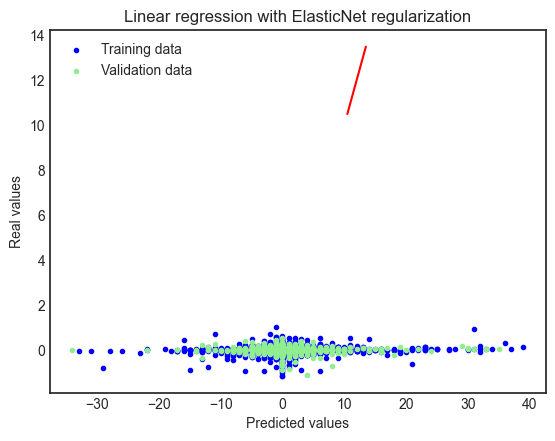

In [159]:
plt.scatter(y_train, pred_train, c = "blue", marker = ".", label = "Training data")
plt.scatter(y_test, pred_test, c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

ElasticNet picked 34 features and eliminated the other 7 features


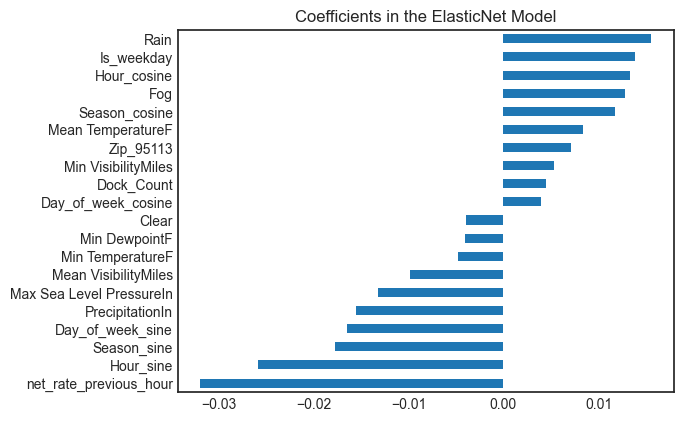

In [160]:
# Важность коэффициентов
coefs = pd.Series(elasticNet.coef_, index = X_train.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                       coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")
plt.show()

### Linear regression with Bayesian Ridge regularization

In [161]:
bayes = BayesianRidge()

In [162]:
bayes.fit(X_train, y_train)

BayesianRidge()

In [163]:
predictions = bayes.predict(X_test)
print(explained_variance_score(predictions,y_test))

-25315.926114156027


In [164]:
# Root Mean Squared Error
print("RMSE: %.2f"
      % math.sqrt(np.mean((bayes.predict(X_test) - y_test) ** 2)))

RMSE: 1.69


In [165]:
predictions = bayes.predict(X_test)
print(explained_variance_score(predictions, y_test))

# Root Mean Squared Error
print("RMSE: %.3f"
      % math.sqrt(np.mean((bayes.predict(X_test) - y_test) ** 2)))

-25315.926114156027
RMSE: 1.692


In [166]:
scoring = 'neg_mean_squared_error'
kfold = KFold(n_splits=5, random_state=seed)
cv_results = cross_val_score(bayes,
                             X, y,
                             cv=kfold,
                             scoring=scoring)

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.


In [167]:
print('RMSE: %.3f (%.3f)' % (cv_results.mean(), cv_results.std()))

RMSE: -2.800 (0.149)


In [168]:
pred_train = bayes.predict(X_train)
pred_test  = bayes.predict(X_test)

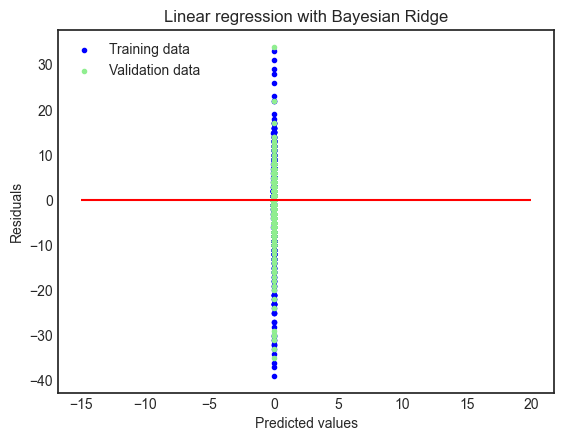

In [169]:
plt.scatter(pred_train, pred_train - y_train, c = "blue", marker = ".", label = "Training data")
plt.scatter(pred_test, pred_test - y_test, c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with Bayesian Ridge")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = -15, xmax = 20, color = "red")
plt.show()

Text(0.5, 1.0, 'Residual plot in Bayesian Regression')

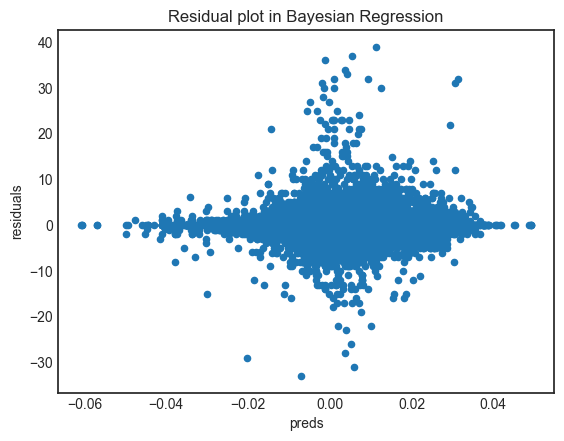

In [170]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":bayes.predict(X_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Residual plot in Bayesian Regression")

In [171]:
plt.scatter(y_train, pred_train, c = "blue", marker = ".", label = "Training data")
plt.scatter(y_test, pred_test, c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with Bayesian Ridge")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

In [172]:
# Важность коэффициентов
coefs = pd.Series(bayes.coef_, index = X_train.columns)
print("Bayesian picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                       coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Bayesian Regression Model")
plt.show()

Bayesian picked 41 features and eliminated the other 0 features


In [177]:
col={'Train Error':pred_train,'Test Error':pred_train}
models=['Ridge Regression',
        'Linear Regression','Elastic Net regression',
        'Bayesian Regression',
        'Random Forest','Gradient Boosting', 
       ]
df_comparison=pd.DataFrame(data=col)#, index=models)
df_comparison.head(5)

Train Error  Test Error
0     0.013809    0.013809
1    -0.005808   -0.005808
2     0.005497    0.005497
3     0.005117    0.005117
4     0.011285    0.011285

<AxesSubplot:>

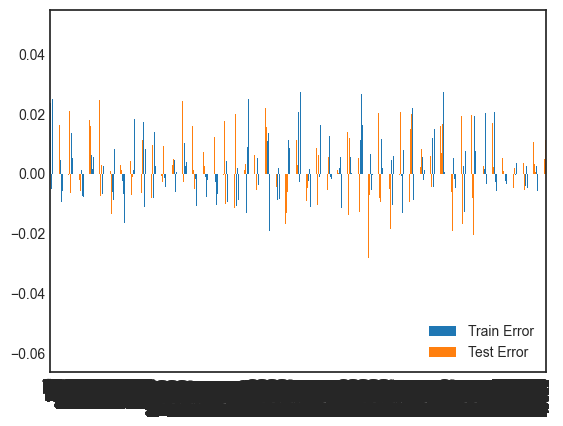

In [178]:
df_comparison.plot(kind='bar')

### Least Angle regression (LARs)

In [179]:
lars = Lars(n_nonzero_coefs=50)

In [180]:
lars.fit(X_train, y_train)

Regressors in active set degenerate. Dropping a regressor, after 36 iterations, i.e. alpha=8.838e-07, with an active set of 34 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 38 iterations, i.e. alpha=6.419e-07, with an active set of 36 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 40 iterations, i.e. alpha=2.805e-07, with an active set of 37 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 42 iterations, i.e. alpha=2.213e-07, with an active set of 38 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.


Lars(n_nonzero_coefs=50)

In [181]:
print("RMSE on Training set :", rmse_cv(lars, X_train, y_train).mean())
print("Test set :", rmse_cv(lars, X_test, y_test).mean())

Regressors in active set degenerate. Dropping a regressor, after 42 iterations, i.e. alpha=1.160e-06, with an active set of 39 regressors, and the smallest cholesky pivot element being 8.025e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 42 iterations, i.e. alpha=1.083e-06, with an active set of 39 regressors, and the smallest cholesky pivot element being 8.025e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 38 iterations, i.e. alpha=1.855e-05, with an active set of 36 regressors, and the smallest cholesky pivot element being 4.942e-08. Reduce max_iter or increase eps parameters.


RMSE on Training set : 1.6688790392351178
Test set : 1.7083850399274516


Regressors in active set degenerate. Dropping a regressor, after 40 iterations, i.e. alpha=1.392e-05, with an active set of 37 regressors, and the smallest cholesky pivot element being 4.942e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 41 iterations, i.e. alpha=5.187e-06, with an active set of 38 regressors, and the smallest cholesky pivot element being 5.771e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 41 iterations, i.e. alpha=2.283e-06, with an active set of 38 regressors, and the smallest cholesky pivot element being 4.942e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 42 iterations, i.e. alpha=1.343e-06, with an active set of 39 regressors, and the smallest cholesky pivot element being 4.942e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dro

In [182]:
predictions = lars.predict(X_test)
print(explained_variance_score(predictions, y_test))

# Root Mean Squared Error
print("RMSE: %.3f"
      % math.sqrt(np.mean((lars.predict(X_test) - y_test) ** 2)))

-841.4367877319426
RMSE: 1.693


In [183]:
scoring = 'neg_mean_squared_error'
kfold = KFold(n_splits=5, random_state=seed)
cv_results = cross_val_score(lars,
                             X, y,
                             cv=kfold,
                             scoring=scoring)

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=4.350e-06, with an active set of 31 regressors, and the smallest cholesky pivot element being 5.475e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=2.964e-06, with an active set of 33 regressors, and the smallest cholesky pivot element being 5.475e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=2.869e-06, with an active set of 33 regressors, and the smallest cholesky pivot element being 5.475e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 36 iterations, i.e. alpha=1.972e-06, with an a

In [184]:
print('RMSE: %.3f (%.3f)' % (cv_results.mean(), cv_results.std()))

RMSE: -2.804 (0.148)


In [185]:
pred_train = lars.predict(X_train)
pred_test  = lars.predict(X_test)

In [186]:
plt.scatter(pred_train, pred_train - y_train, 
            c = "blue", marker = ".", label = "Training data")
plt.scatter(pred_test, pred_test - y_test, 
            c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with Least Angle Regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = -15, xmax = 20, color = "red")
plt.show()

In [187]:
plt.scatter(y_train, pred_train, c = "blue", marker = ".", label = "Training data")
plt.scatter(y_test, pred_test, c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with Least Angle Regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

LARS picked 38 features and eliminated the other 3 features


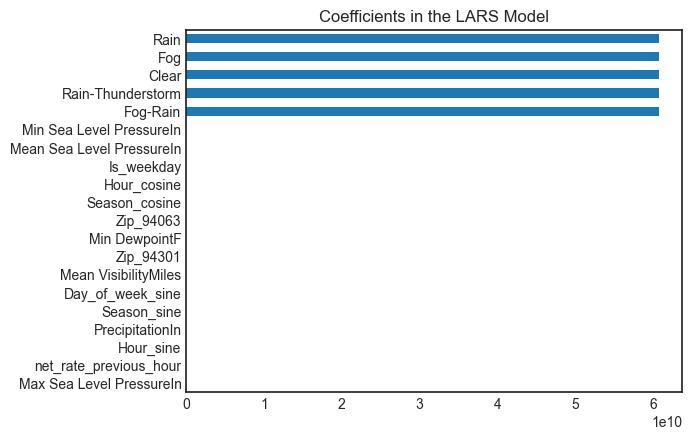

In [188]:
# Важность коэффициентов
coefs = pd.Series(lars.coef_, index = X_train.columns)
print("LARS picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the LARS Model")
plt.show()

## Tree-based regression

### Random Forest Regressor

In [189]:
rfr = RandomForestRegressor(n_jobs=1, criterion='mse', random_state=42)

In [190]:
rfr.fit(X_train, y_train)

RandomForestRegressor(n_jobs=1, random_state=42)

In [191]:
predictions = rfr.predict(X_test)
print(explained_variance_score(predictions,y_test))

-2.6205157434070494


In [192]:
# Root Mean Squared Error
print("RMSE: %.2f"
      % math.sqrt(np.mean((rfr.predict(X_test) - y_test) ** 2)))

RMSE: 1.76


In [193]:
scoring = 'neg_mean_squared_error'
kfold = KFold(n_splits=5, random_state=seed)
cv_results = cross_val_score(rfr,
                             X, y,
                             cv=kfold,
                             scoring=scoring)

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.


In [194]:
print('RMSE: %.3f (%.3f)' % (cv_results.mean(), cv_results.std()))

RMSE: -2.982 (0.202)


In [195]:
pred_train = rfr.predict(X_train)
pred_test  = rfr.predict(X_test)

In [196]:
plt.scatter(pred_train, pred_train - y_train, 
            c = "blue", marker = ".", label = "Training data")
plt.scatter(pred_test, pred_test - y_test, 
            c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with Random Forest")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = -15, xmax = 20, color = "red")
plt.show()

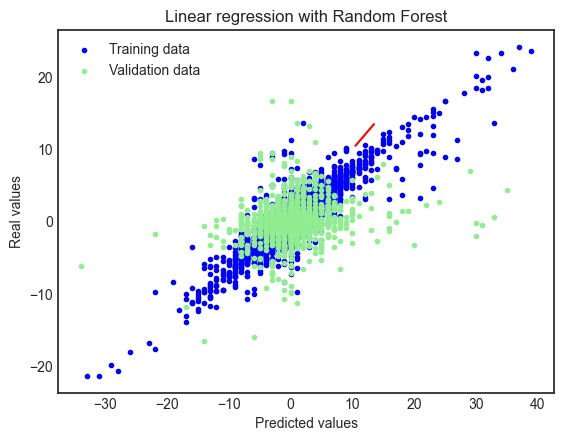

In [197]:
plt.scatter(y_train, pred_train, c = "blue", marker = ".", label = "Training data")
plt.scatter(y_test, pred_test, c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with Random Forest")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

RandomForest picked 41 features and eliminated the other 0 features


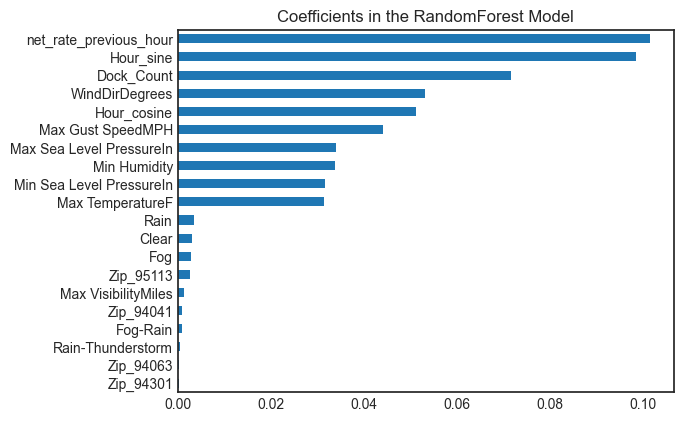

In [198]:
# Важность коэффициентов
coefs = pd.Series(rfr.feature_importances_, index = X_train.columns)
print("RandomForest picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                       coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the RandomForest Model")
plt.show()

In [199]:
lassolarsic = LassoLarsIC()

In [200]:
lassolarsic.fit(X_train, y_train)

LassoLarsIC()

In [201]:
predictions = lassolarsic.predict(X_test)
print(explained_variance_score(predictions,y_test))

-2535.428014092965


In [202]:
# Calculate the Root Mean Squared Error
print("RMSE: %.2f"
      % math.sqrt(np.mean((lassolarsic.predict(X_test) - y_test) ** 2)))

RMSE: 1.69


In [203]:
scoring = 'neg_mean_squared_error'
kfold = KFold(n_splits=5, random_state=seed)
cv_results = cross_val_score(lassolarsic,
                             X, y,
                             cv=kfold,
                             scoring=scoring)

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.


In [204]:
print('RMSE: %.3f (%.3f)' % (cv_results.mean(), cv_results.std()))

RMSE: -2.801 (0.148)


In [205]:
pred_train = lassolarsic.predict(X_train)
pred_test  = lassolarsic.predict(X_test)

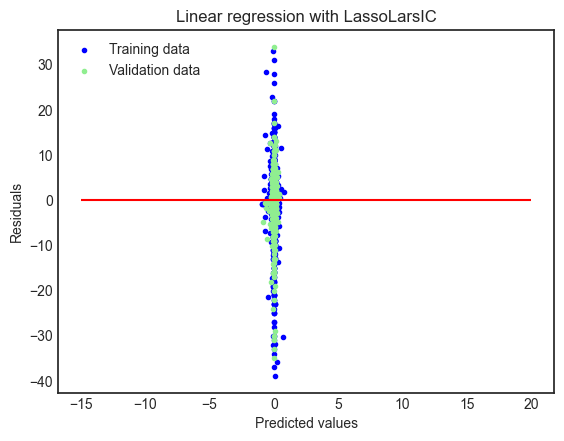

In [206]:
plt.scatter(pred_train, pred_train - y_train, 
            c = "blue", marker = ".", label = "Training data")
plt.scatter(pred_test, pred_test - y_test, 
            c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with LassoLarsIC")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = -15, xmax = 20, color = "red")
plt.show()

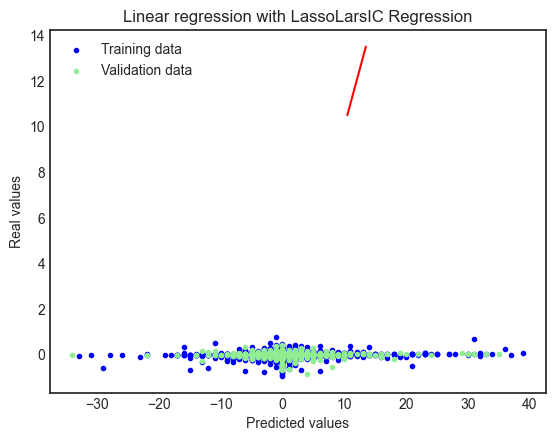

In [207]:
plt.scatter(y_train, pred_train, c = "blue", marker = ".", label = "Training data")
plt.scatter(y_test, pred_test, c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with LassoLarsIC Regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

LassoLarsIC picked 4 features and eliminated the other 37 features


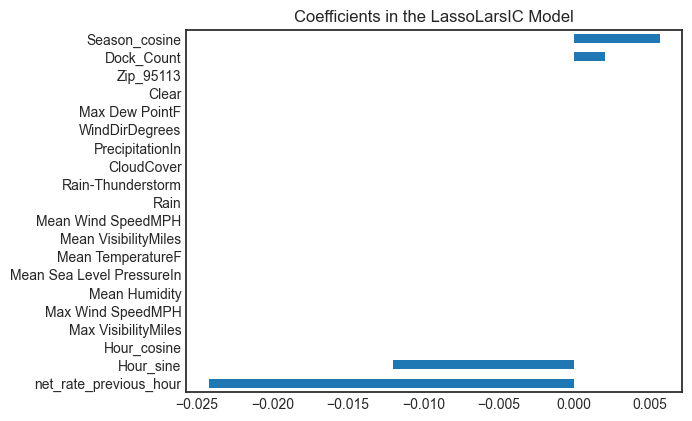

In [208]:
# Важность коэффициентов
coefs = pd.Series(lassolarsic.coef_, index = X_train.columns)
print("LassoLarsIC picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                       coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the LassoLarsIC Model")
plt.show()

### Gradient Boosting Regressor

In [209]:
##Gradient Boosting Regressor

# nested cross-validation
gbr = GradientBoostingRegressor(criterion='friedman_mse', 
                                subsample=0.80,
                                max_features='auto',
                                random_state=42)

In [210]:
gbr.fit(X_train, y_train)

GradientBoostingRegressor(max_features='auto', random_state=42, subsample=0.8)

In [211]:
predictions = gbr.predict(X_test)
print(explained_variance_score(predictions,y_test))

-31.298493013986786


In [212]:
# Root Mean Squared Error
print("RMSE: %.2f"
      % math.sqrt(np.mean((gbr.predict(X_test) - y_test) ** 2)))

RMSE: 1.68


In [213]:
scoring = 'neg_mean_squared_error'
kfold = KFold(n_splits=5, random_state=seed)
cv_results = cross_val_score(gbr,
                             X, y,
                             cv=kfold,
                             scoring=scoring)

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.


In [214]:
print('RMSE: %.3f (%.3f)' % (cv_results.mean(), cv_results.std()))

RMSE: -2.736 (0.136)


In [215]:
pred_train = gbr.predict(X_train)
pred_test  = gbr.predict(X_test)

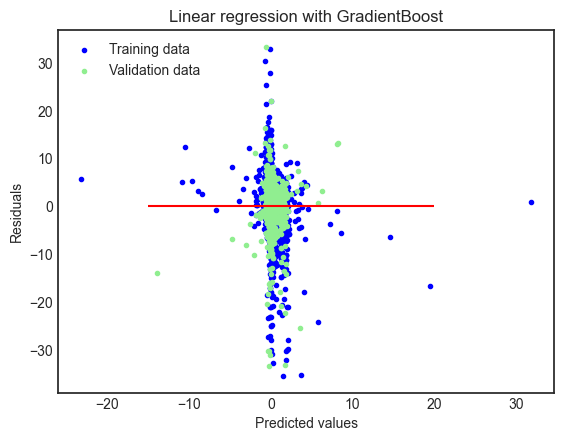

In [216]:

plt.scatter(pred_train, pred_train - y_train, 
            c = "blue", marker = ".", label = "Training data")
plt.scatter(pred_test, pred_test - y_test, 
            c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with GradientBoost")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = -15, xmax = 20, color = "red")
plt.show()

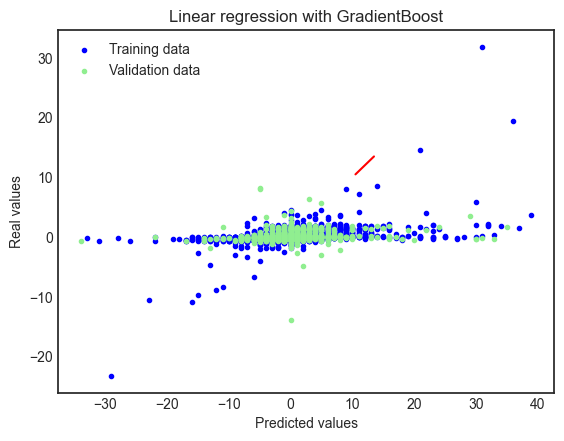

In [217]:

plt.scatter(y_train, pred_train, c = "blue", marker = ".", label = "Training data")
plt.scatter(y_test, pred_test, c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with GradientBoost")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

XGBoost picked 31 features and eliminated the other 10 features


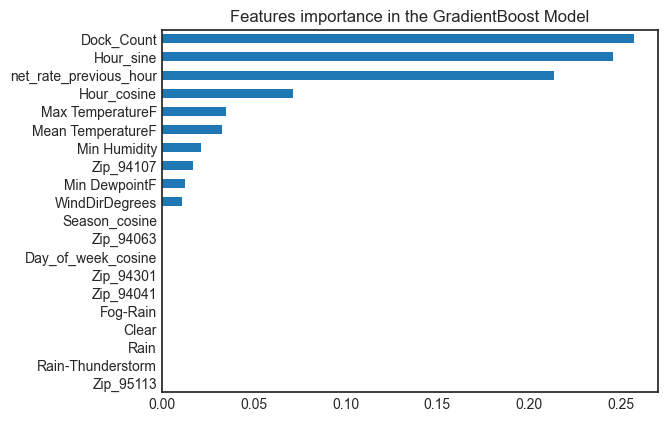

In [218]:

coefs = pd.Series(gbr.feature_importances_, index = X_train.columns)
print("XGBoost picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                       coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Features importance in the GradientBoost Model")
plt.show()

### XGBoost Regressor

In [219]:
## Fitting XGBoost regressor

# nested cross-validation
xgbr = XGBRegressor()

In [220]:
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [221]:
predictions = xgbr.predict(X_test)
print(explained_variance_score(predictions,y_test))

-5.633920305846905


In [222]:
# Root Mean Squared Error
print("RMSE: %.2f"
      % math.sqrt(np.mean((xgbr.predict(X_test) - y_test) ** 2)))

RMSE: 1.66


In [223]:
scoring = 'neg_mean_squared_error'
kfold = KFold(n_splits=5, random_state=seed)
cv_results = cross_val_score(xgbr,
                             X, y,
                             cv=kfold,
                             scoring=scoring)

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.


In [224]:
print('RMSE: %.3f (%.3f)' % (cv_results.mean(), cv_results.std()))

RMSE: -2.803 (0.191)


In [225]:
pred_train = xgbr.predict(X_train)
pred_test  = xgbr.predict(X_test)

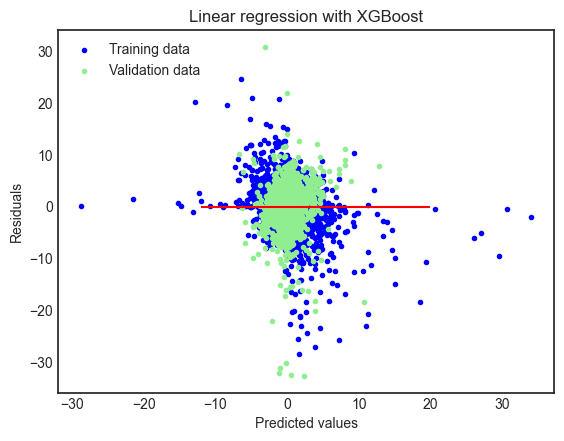

In [226]:

plt.scatter(pred_train, pred_train - y_train, 
            c = "blue", marker = ".", label = "Training data")
plt.scatter(pred_test, pred_test - y_test, 
            c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with XGBoost")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = -12, xmax = 20, color = "red")
plt.show()

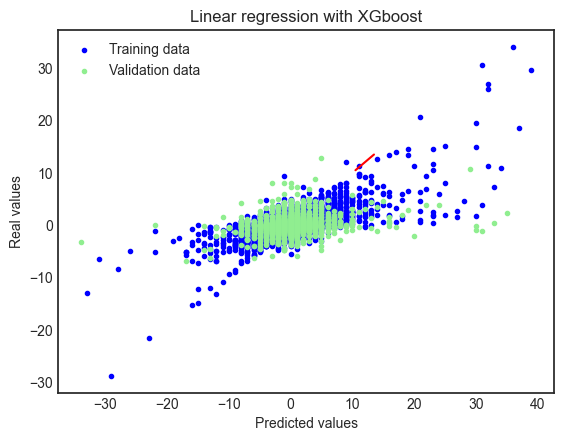

In [227]:

plt.scatter(y_train, pred_train, c = "blue", marker = ".", label = "Training data")
plt.scatter(y_test, pred_test, c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with XGboost")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

XGBoost picked 41 features and eliminated the other 0 features


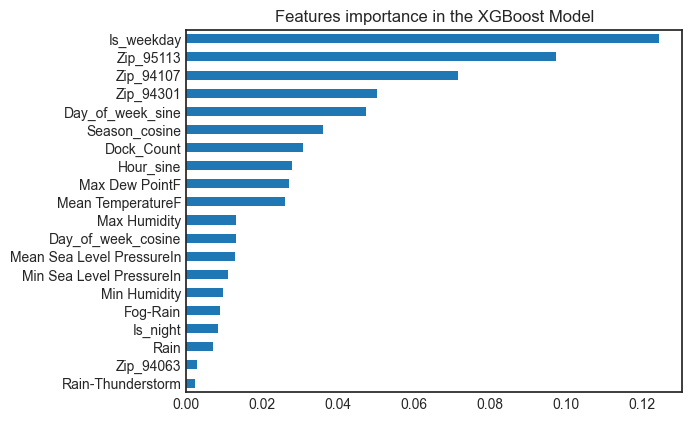

In [228]:
# Важность коэф
coefs = pd.Series(xgbr.feature_importances_, index = X_train.columns)
print("XGBoost picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                       coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Features importance in the XGBoost Model")
plt.show()

#### Regression model comparison

Определяем основную модель для дальнейшей работы

In [229]:
%%time
# подготовка
models = []
models.append(('linear', LinearRegression()))
models.append(('lasso', Lasso()))
models.append(('ridge', Ridge()))
models.append(('elasticnet', ElasticNet()))
models.append(('bayesridge', BayesianRidge()))
models.append(('lars', Lars(n_nonzero_coefs=50)))
models.append(('lassolarsic', LassoLarsIC()))
models.append(('randomforest', RandomForestRegressor()))
models.append(('gradientboost', GradientBoostingRegressor()))
models.append(('xgboost', XGBRegressor()))

# оценка моделей
results = []
names = []
scoring = 'neg_mean_squared_error'

for name, model in models:

    kfold = KFold(n_splits=5, random_state=seed)
    
    cv_results = cross_val_score(model,
                                 X, y,
                                 cv=kfold,
                                 scoring=scoring)
    results.append((-1)*cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, (-1)*cv_results.mean(), cv_results.std())
    print(msg)

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.


linear: 2.803339 (0.147881)


Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.


lasso: 2.799933 (0.149480)


Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.


ridge: 2.803298 (0.147860)


Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.


elasticnet: 2.800021 (0.149418)


Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.


bayesridge: 2.800339 (0.148812)


Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=4.350e-06, with an active set of 31 regressors, and the smallest cholesky pivot element being 5.475e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=2.964e-06, with an active set of 33 regressors, and the smallest cholesky pivot element being 5.475e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=2.869e-06, with an active set of 33 regressors, and the smallest cholesky pivot element being 5.475e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 36 iterations, i.e. alpha=1.972e-06, with an a

lars: 2.804478 (0.148423)
lassolarsic: 2.801055 (0.148286)


Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.


randomforest: 2.990155 (0.193671)


Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.


gradientboost: 2.766581 (0.150930)


Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.


xgboost: 2.803065 (0.190925)
Wall time: 9min 45s


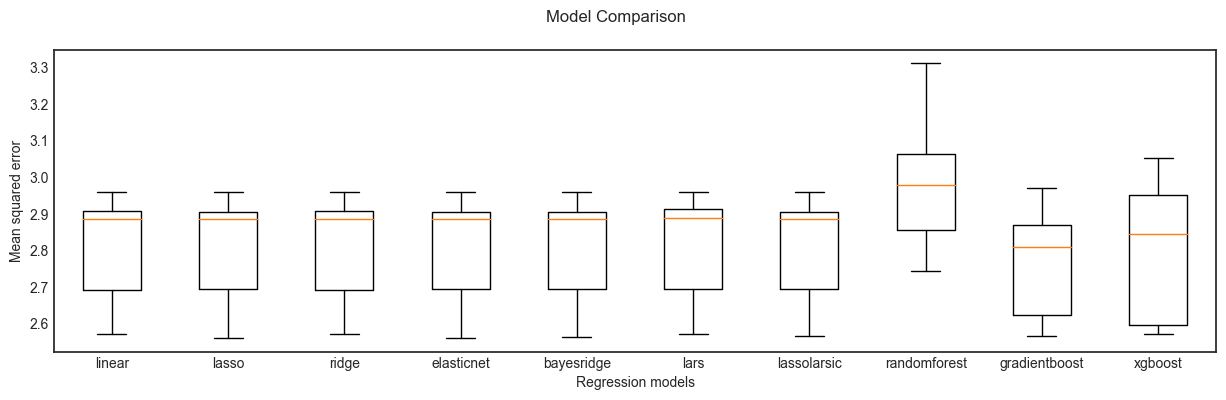

In [230]:
# Выводим boxplot по результатам
fig = plt.figure(figsize=(15,4))
fig.suptitle('Model Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names) 
ax.set_ylabel('Mean squared error')
ax.set_xlabel('Regression models')
plt.show()

### Learning Curves

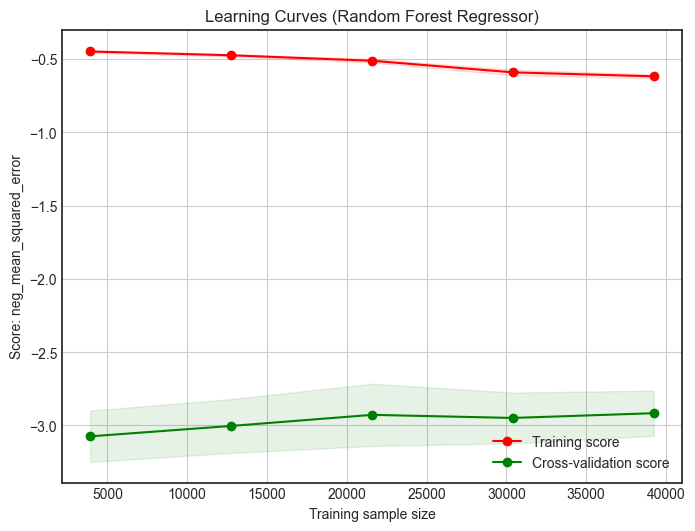

None

In [231]:
#
pipe = make_pipeline(rfr)

title = "Learning Curves (Random Forest Regressor)"

plot_learning_curve(pipe, title, X_train, y_train, 
                    cv=None, 
                    scoring='neg_mean_squared_error', 
                    n_jobs=1,
                    train_sizes=np.linspace(.1, 1.0, 5))

In [241]:
#from sklearn.model_selection import validation_curve
from sklearn import model_selection
## Define validation plots
def validation_curve(estimators, X_train, y_train, param_name,
                     params, param_range, cv=3,
                     scoring="neg_mean_squared_error", logx=False,
                     n_jobs=1):
    """
    Draw histogram of the DataFrame's series comparing the distribution
    in `signal` to `background`.
    Parameters
    ----------
    models : dictionary, shape = [n_models]
    X : DataFrame, shape = [n_samples, n_classes]
    y : DataFrame, shape = [n_classes]
    param_range :
    param_name :
    cv :
    scoring :
    n_jobs :
    Returns
    -------
    plot : matplotlib plot
    """

    """
    Describe possible kwargs values
    Keys
    ----------
    """

    # deep compy of model(s)
    models = estimators

    # line width
    lw = 2

    # check to see if models is a list
    if not isinstance(models, list):
        models = [models]
    # check to see if model is a pipeline object or not
    if isinstance(models[0], sklearn.pipeline.Pipeline):
        data_type = type(models[0]._final_estimator)
    else:
        data_type = type(models[0])

    # plot title
    name = filter(str.isalnum, str(data_type).split(".")[-1])
    title = "Validation Curves (%s)" % name

    # create blank canvas
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.grid(which='major', linestyle='-', linewidth='0.2', color='gray')
    #ax.set_facecolor('white')

    for n, model in enumerate(models):
        print('start validation scores ...')
        #print(model.get_params().keys())
        # validation scores
        print('param_name:', param_name)
        print('param_range:', param_range)
        train_scores, test_scores = model_selection.validation_curve(
            model, X_train, y_train,
            param_name=param_name,
            param_range=param_range, cv=cv,
            scoring=scoring, n_jobs=n_jobs)
        print('end validation scores ...')
        # mean train scores
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std  = np.std(train_scores, axis=1)

        # mean test scores
        test_scores_mean  = np.mean(test_scores, axis=1)
        test_scores_std   = np.std(test_scores, axis=1)

        # extract information for legend
        label = 'placeholder'

        # plot validation curve
        if logx is True:
            plt.semilogx(param_range, train_scores_mean, '--',
                         label=label.replace('placeholder','Training'),
                         color="darkorange", lw=lw)

            plt.semilogx(param_range, test_scores_mean,
                         label=label.replace('placeholder','Test'),
                         color="navy", lw=lw)
        else:
            plt.plot(param_range, train_scores_mean, '--',
                     label=label.replace('placeholder','Training'),
                     color="darkorange", lw=lw)

            plt.plot(param_range, test_scores_mean,
                     label=label.replace('placeholder','Test'),
                     color="navy", lw=lw)

        plt.fill_between(param_range, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.2,
                         color="darkorange", lw=lw)

        plt.fill_between(param_range, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.2,
                         color="navy", lw=lw)

        #colour = test_line[-1].get_color()
        #plt.axvline(x=best_iter, color=colour)

    # plot title
    plt.title(title, fontsize=14)

    plt.xlabel(str(param_name).replace('__',''))
    plt.ylabel(scoring)

    # x-axis range
    plt.xlim([min(param_range), max(param_range)])

    plt.legend(loc='best', frameon=False, fancybox=True, fontsize=12)

    return plt.show()

In [236]:
estimator = RandomForestRegressor(n_jobs=1, criterion='mse', 
                                  min_samples_leaf=10, random_state=seed)
# n_estimators=10,  max_depth=None, criterion=’mse’, min_samples_leaf=1,

start validation scores ...
param_name: n_estimators
param_range: [ 2 10 18 26]
end validation scores ...


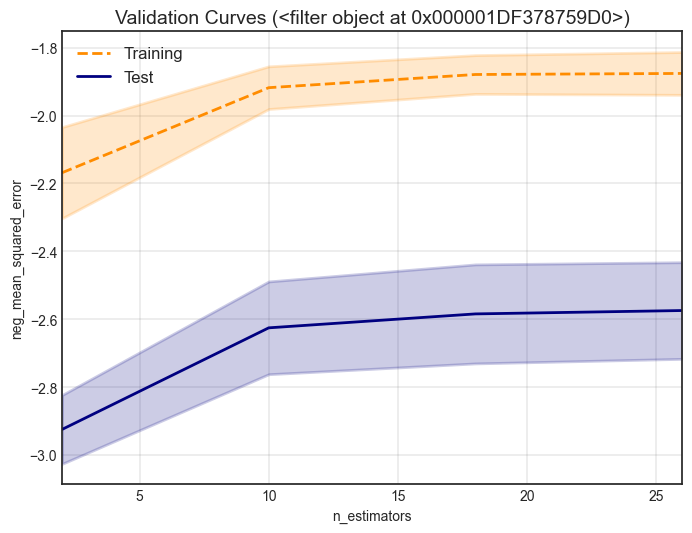

In [242]:
# Гипер - параметры  и валидация
name = 'estimator'#.lower()

#param_name = name+'__alpha'
param_name = 'n_estimators'
param_range = np.linspace(2, 26, num=4, dtype=int)
#params = {name.lower()+'__alpha': 1}
params = {'n_estimators': 1}

validation_curve(estimator,
                 X_train, y_train,
                 param_name,
                 params,
                 param_range,
                 scoring="neg_mean_squared_error",
                 cv=3
                )

start validation scores ...
param_name: max_depth
param_range: [4, 5, 6, 7, 8, 9, 10, 15, 25]
end validation scores ...


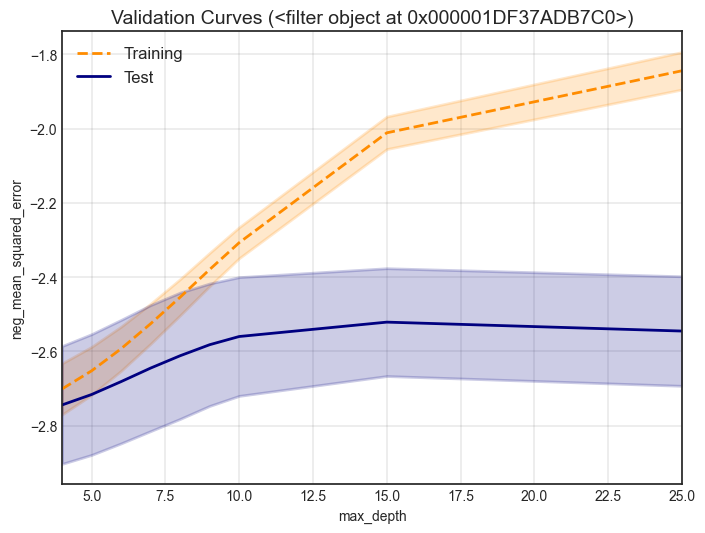

Wall time: 13min 15s


In [243]:
%%time
name = 'estimator'

param_name = 'max_depth'
param_range = [4, 5, 6, 7, 8, 9, 10, 15, 25] #np.linspace(2, 5, num=1, dtype=int)
params = {'max_depth': param_range}

validation_curve(estimators=estimator,
                 X_train=X_train, 
                 y_train=y_train,
                 param_name=param_name,
                 params=params,
                 param_range=param_range,
                 scoring="neg_mean_squared_error",
                 cv=3
                )

start validation scores ...
param_name: min_samples_leaf
param_range: [1, 5, 10, 15]
end validation scores ...


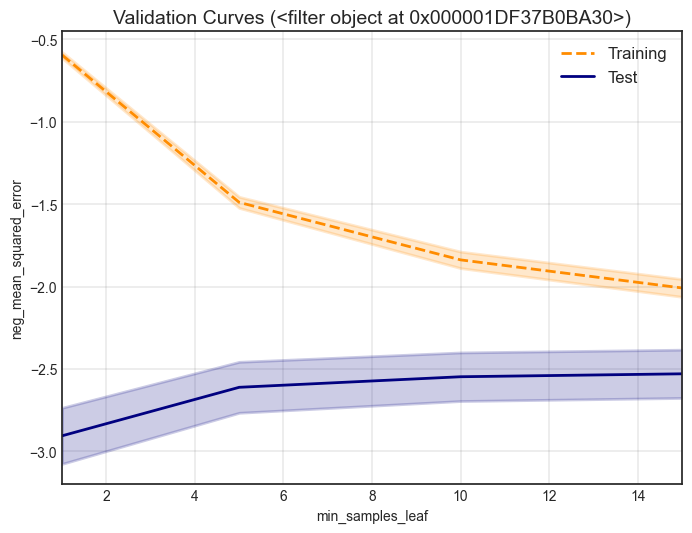

In [244]:
name = 'estimator'

param_name = 'min_samples_leaf'
param_range = [1, 5, 10, 15]#np.linspace(1, 11, num=2, dtype=int)
params = {name.lower()+'min_samples_leaf': 1}

validation_curve(estimator,
                 X_train, y_train,
                 param_name,
                 params,
                 param_range,
                 scoring="neg_mean_squared_error",
                 cv=3
                )

### Model tuning with Bayesian Optimization

In [245]:
 from sklearn.model_selection import StratifiedKFold
    
# кол-во шагов
n_calls = 11

# K-fold stratified cross-validaiton
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)

In [247]:
import skopt
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer

#
space  = [
    Integer(15, 35,                       name='n_estimators'),
    Integer(10, 30,                       name='max_depth'),
    Integer(5,  10,                       name='min_samples_leaf'),
    #Real(10**-3, 9.*10**-1, "log-uniform", name='amma'),
    #Real(10**-3, 9.*10**-1, "log-uniform", name='learning_rate'),   
]

In [248]:
skopt.__version__

'0.8.1'

In [250]:
# декоратор для передаче параметров, как ключевые аргументы 
# используем scikit оболочку

@use_named_args(space)
def objective(**params):

    estimator.set_params(**params)
    
    score = -np.mean(cross_val_score(estimator, 
                                     X, y, #X_train, y_train
                                     cv=3, 
                                     #n_jobs=-1,
                                     scoring="neg_mean_absolute_error"))

    return score

In [251]:
%%time
print('Processing Bayesian optimization...')

# Bayesian optimization
estimator_gp_ei = gp_minimize(func=objective,           # функция минимизации
                              dimensions=space,         # пространство оптимизации
                              acq_func="EI",            # выбор функции ("EI", "LCB", "PI")
                              n_calls=n_calls,          # кол-во итераций
                              random_state=seed,        # seed  
                              #x0=default_parameters,   # базовое значение для помощи поиска
                              n_jobs=1)                 # кол-во потоков

Processing Bayesian optimization...
Wall time: 7min


In [253]:
print("Best score=%.4f (EI)" % estimator_gp_ei.fun)
print("""Expected Improvement (EI) best parameters:
- n_estimators= %s  
- max_depth= %s
- min_samples_leaf= %s """ % (str(estimator_gp_ei.x[0]), str(estimator_gp_ei.x[1]),
                              str(estimator_gp_ei.x[2])))

Best score=0.6019 (EI)
Expected Improvement (EI) best parameters:
- n_estimators= 34  
- max_depth= 10
- min_samples_leaf= 10 


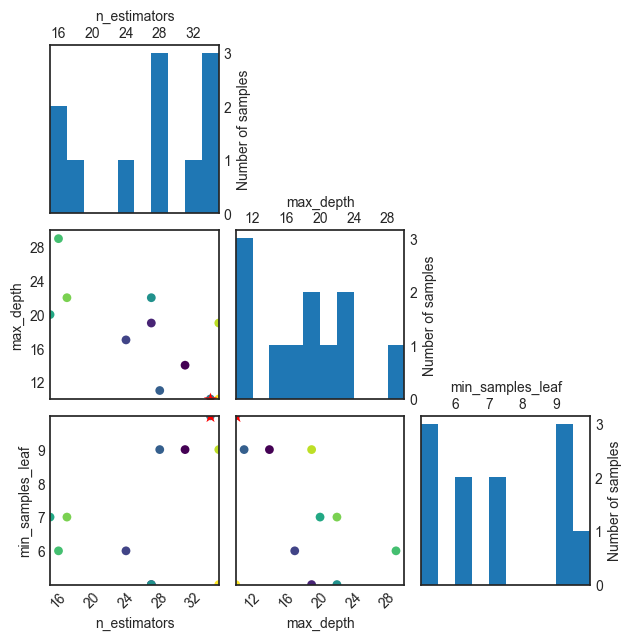

In [254]:
from skopt.plots import plot_evaluations

plot_evaluations(estimator_gp_ei, bins=10, 
                 dimensions=['n_estimators', 'max_depth', 'min_samples_leaf'])
plt.show()

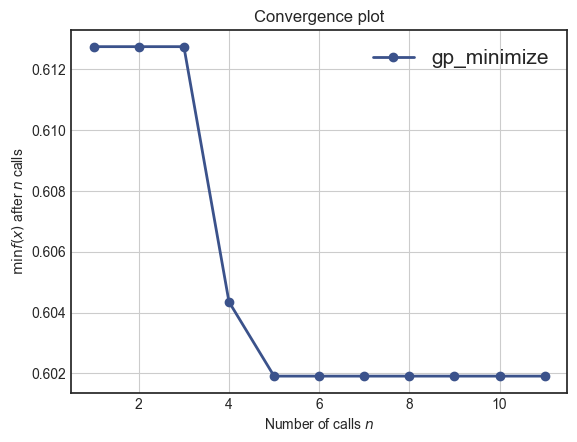

In [255]:
from skopt.plots import plot_convergence

# Сходимость
plot_convergence(("gp_minimize", estimator_gp_ei));
plt.legend(loc="best", prop={'size': 15}, numpoints=1);
plt.show()

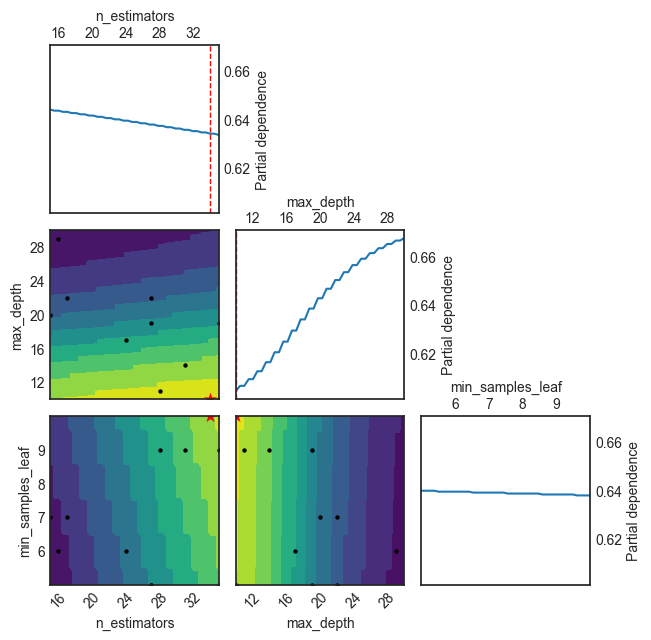

In [256]:
from skopt.plots import plot_objective

plot_objective(estimator_gp_ei)
plt.show()

Best score=0.5309 (EI)

Expected Improvement (EI) best parameters:

- n_estimators= 32  
- max_depth= 12
- min_samples_leaf= 3 

In [257]:
classifier = RandomForestRegressor(n_estimators= 32, 
                                   max_depth= 12,
                                   min_samples_leaf= 3,
                                   criterion='mse', 
                                   random_state=seed)

In [258]:
classifier.fit(X, y)

RandomForestRegressor(max_depth=12, min_samples_leaf=3, n_estimators=32,
                      random_state=42)

In [259]:
# Root Mean Squared Error
print("RMSE: %.2f"
      % math.sqrt(np.mean((classifier.predict(X_test) - y_test) ** 2)))

RMSE: 1.49


### Save & Test model

In [302]:
import pickle

filename = 'model1.pkl'
pickle.dump(classifier, open(filename, 'wb'))

 
# load 
loaded_model = pickle.load(open(filename, 'rb'))
# Root Mean Squared Error
print("RMSE: %.2f"
      % math.sqrt(np.mean((loaded_model.predict(X_test) - y_test) ** 2)))

RMSE: 1.49


## Model interpretability

Используем Shap для визуализации интерпритации результатов модели

In [264]:
shap.initjs()

estimator = rfr #RandomForestRegressor(n_jobs=1, criterion='mse', random_state=42)
#estimator.fit(X_train, y_train)

In [265]:
# Объяснятов
shap_explainer = shap.TreeExplainer(estimator)
#shap_explainer = shap.KernelExplainer(estimator.predict, X_test)

In [266]:
test_shap_vals = shap_explainer.shap_values(X_test[0:100])

In [267]:
shap.force_plot(shap_explainer.expected_value, test_shap_vals[90, :], X_test.iloc[90, :])

auto_size_plot=False is deprecated and is now ignored! Use plot_size=None instead.


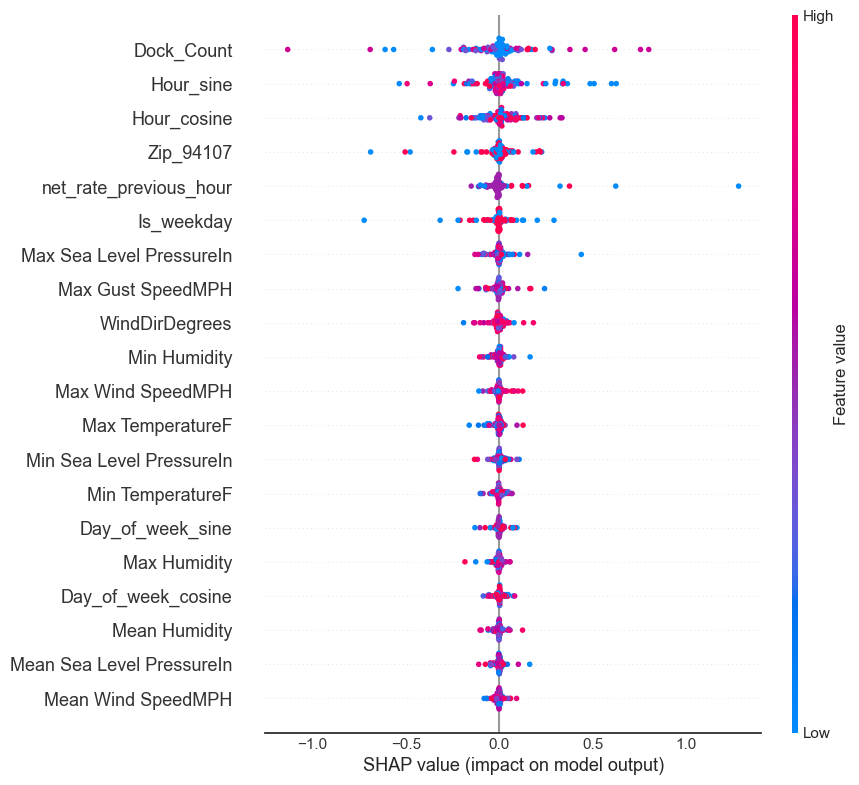

In [268]:
shap.summary_plot(test_shap_vals, X_test[0:100], auto_size_plot=False)

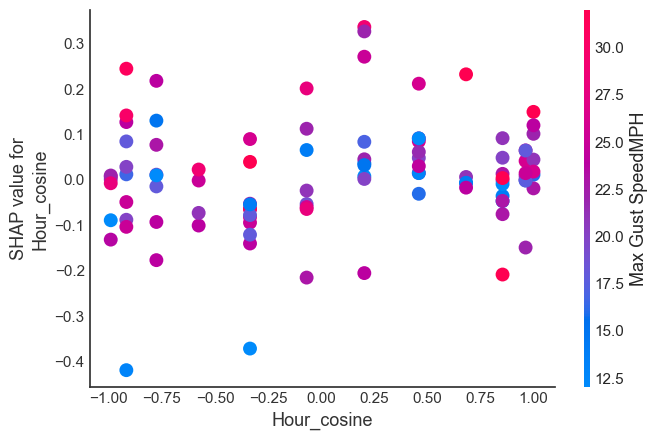

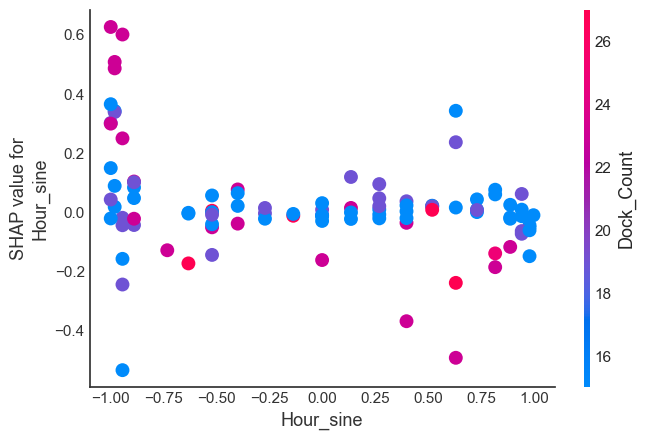

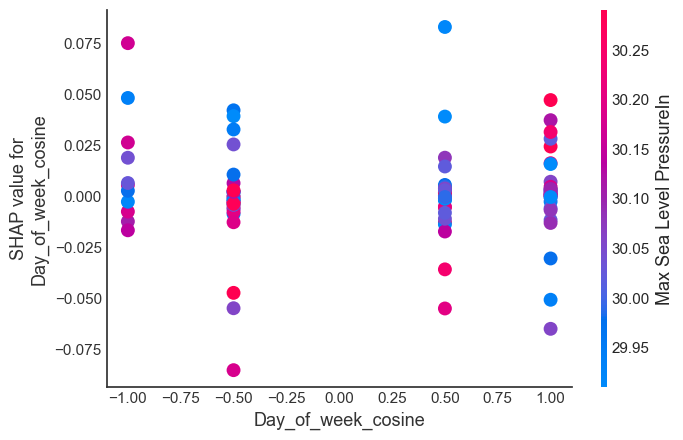

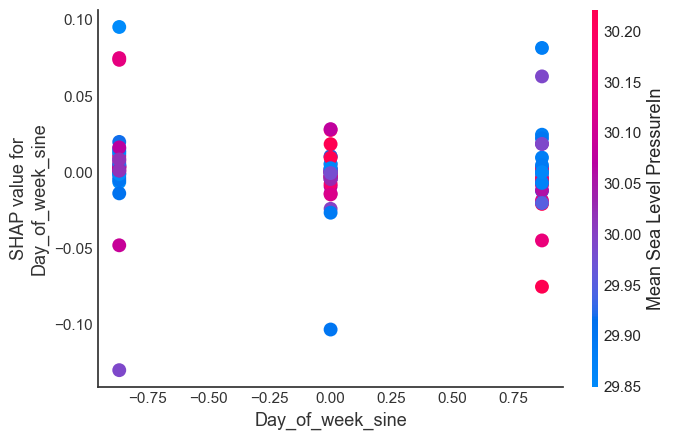

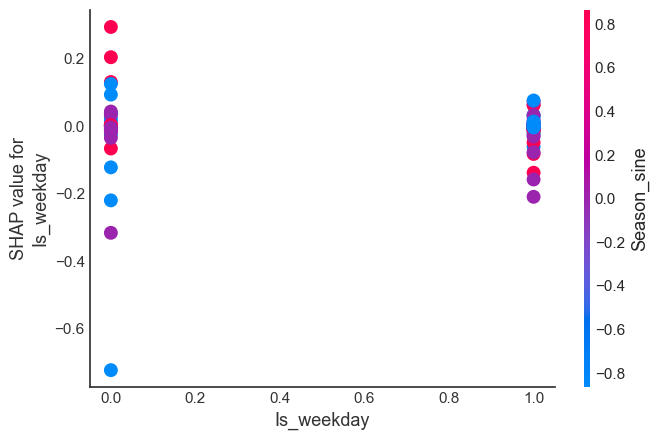

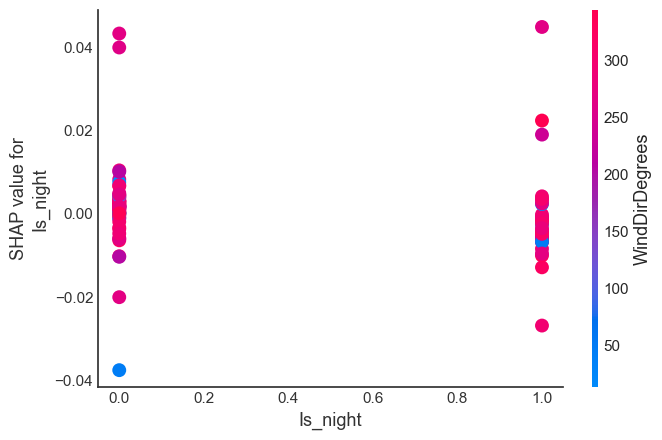

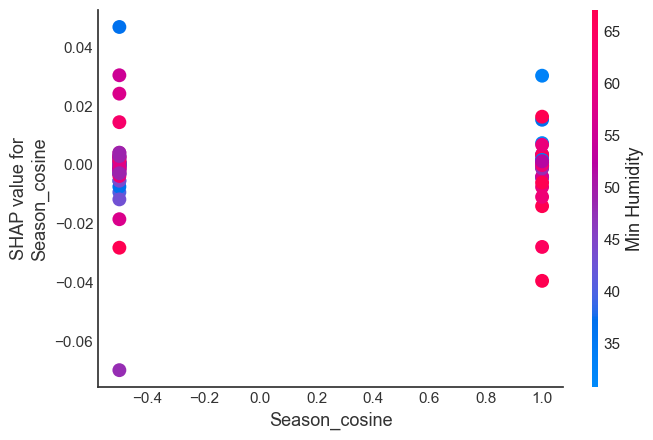

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


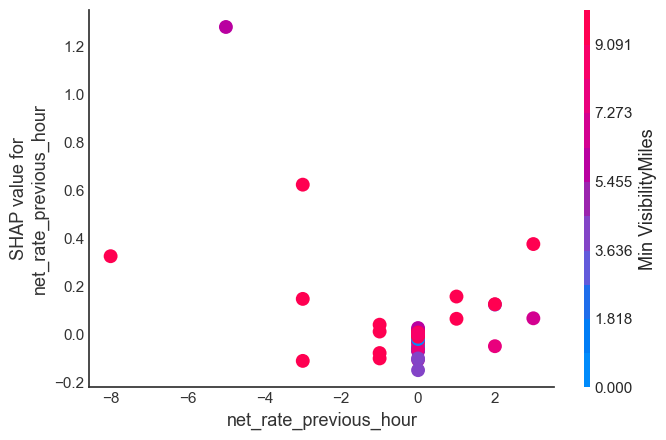

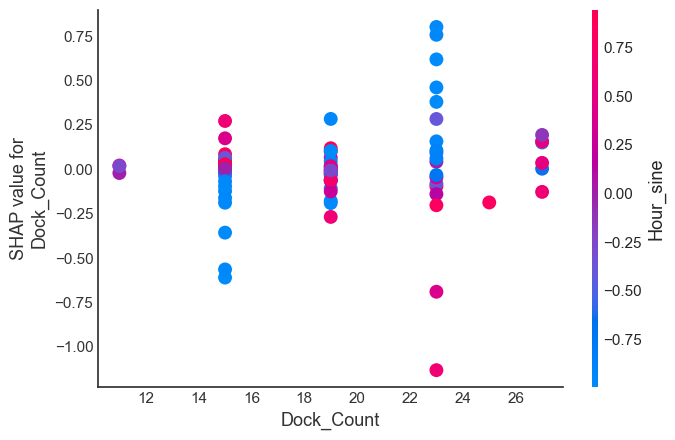

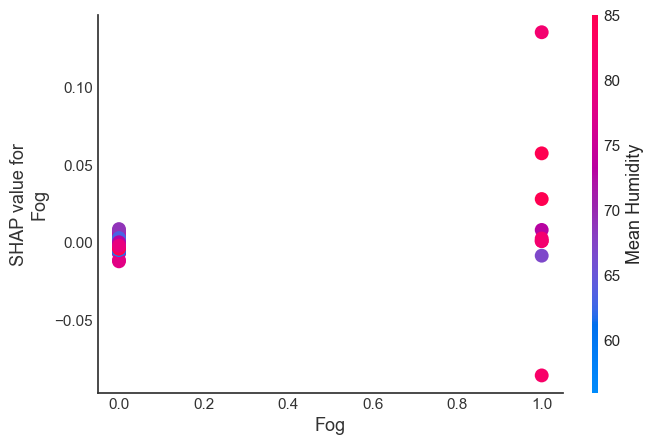

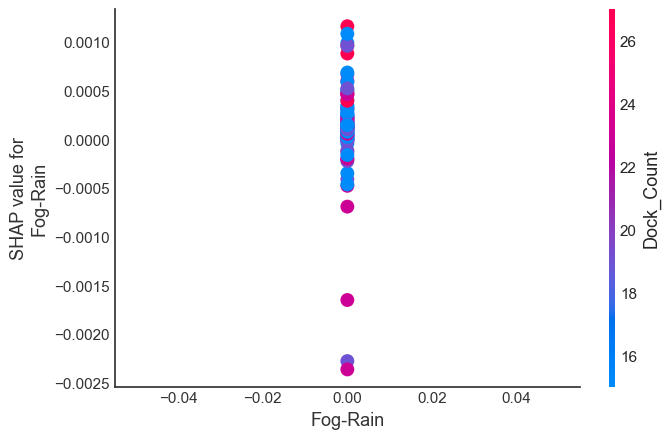

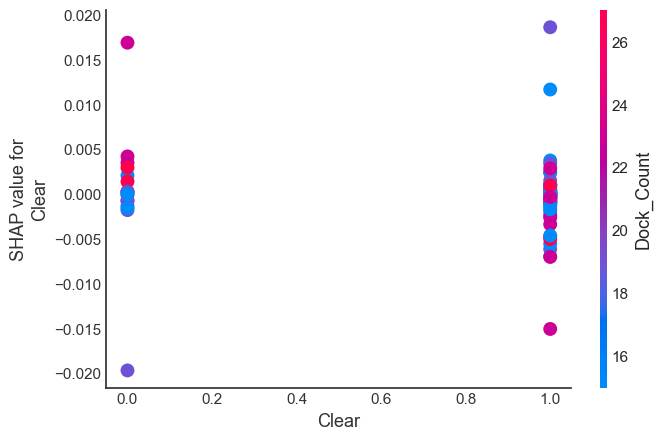

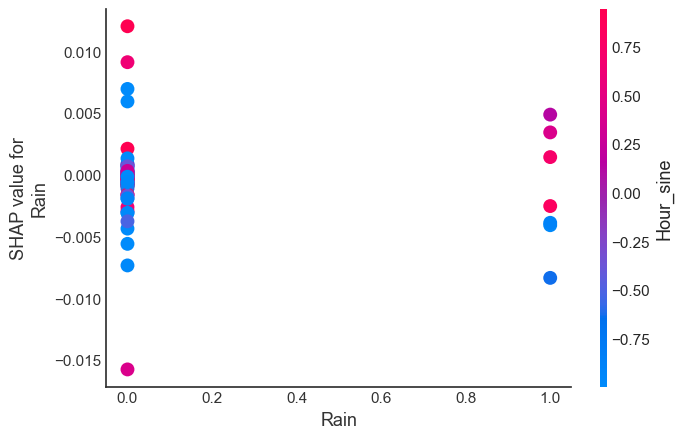

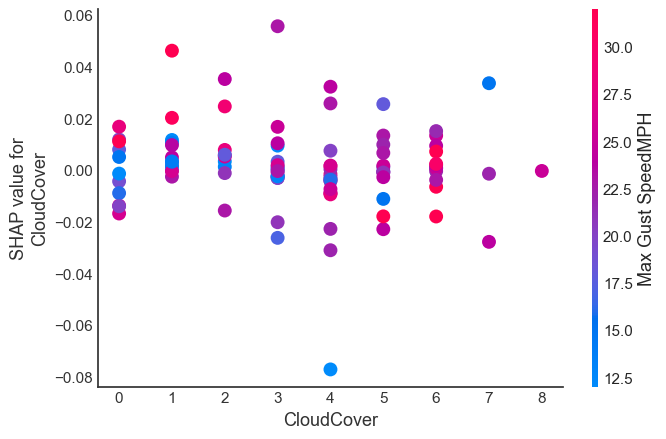

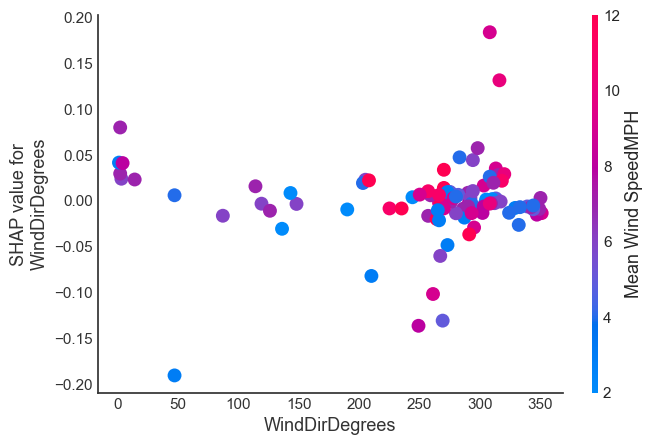

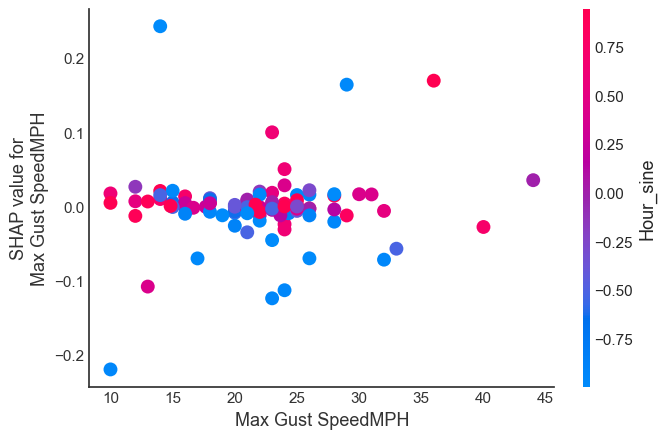

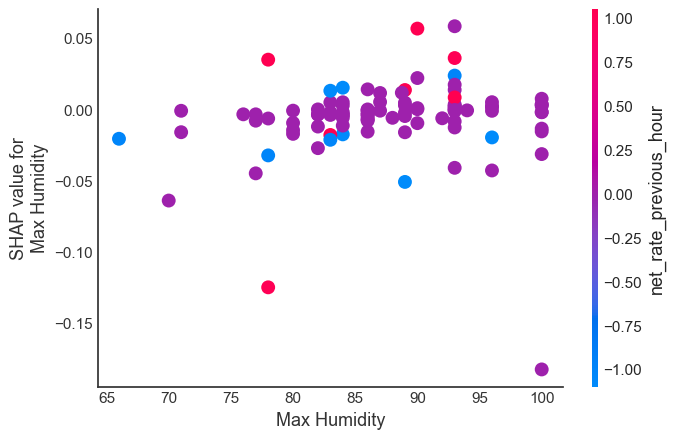

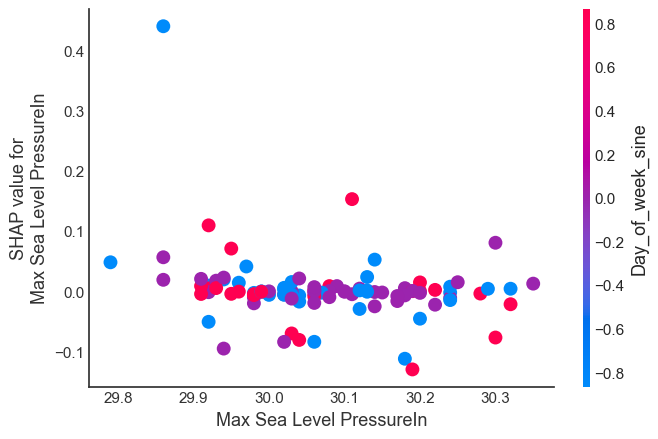

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


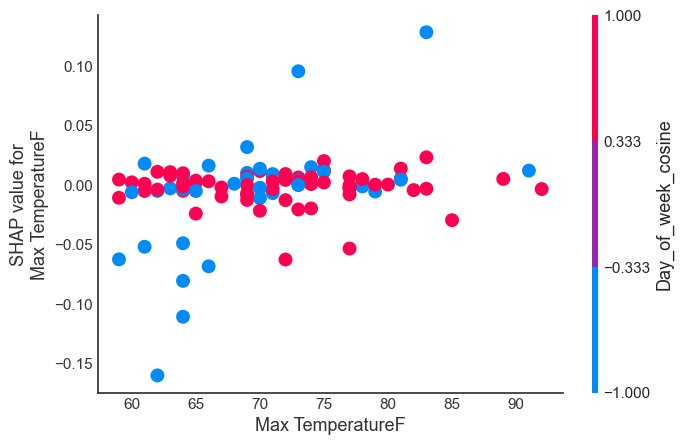

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


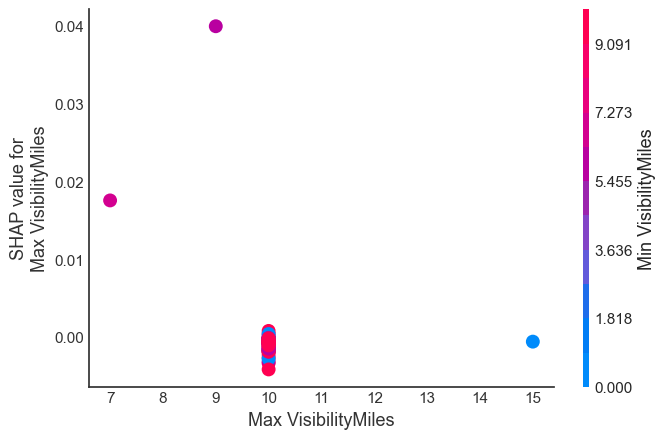

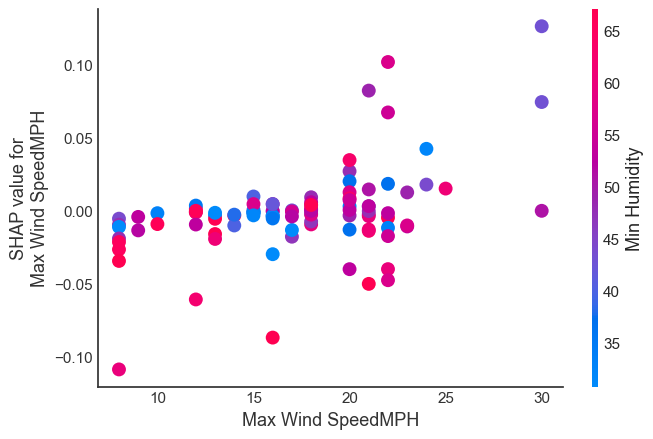

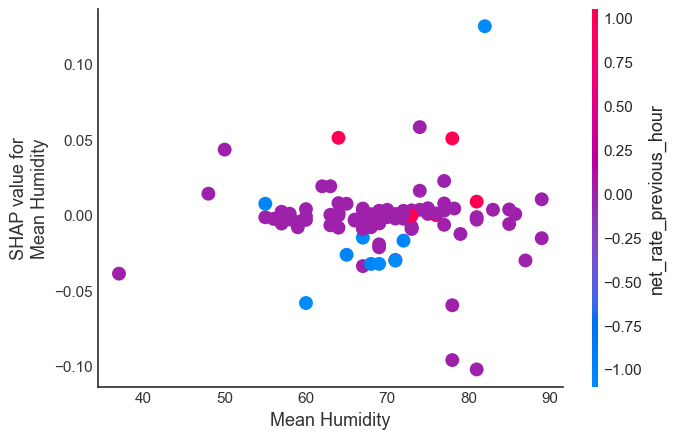

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


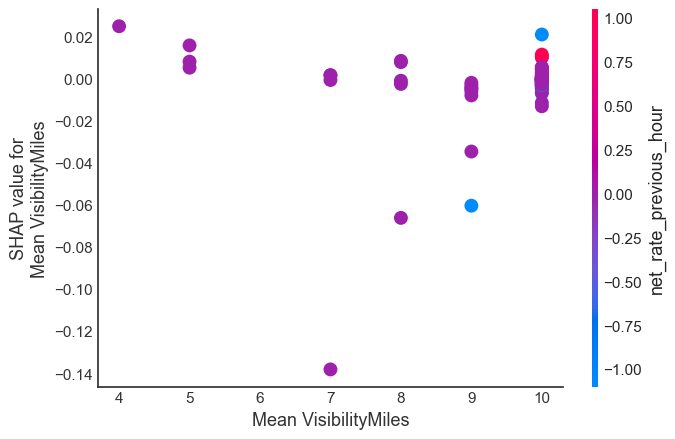

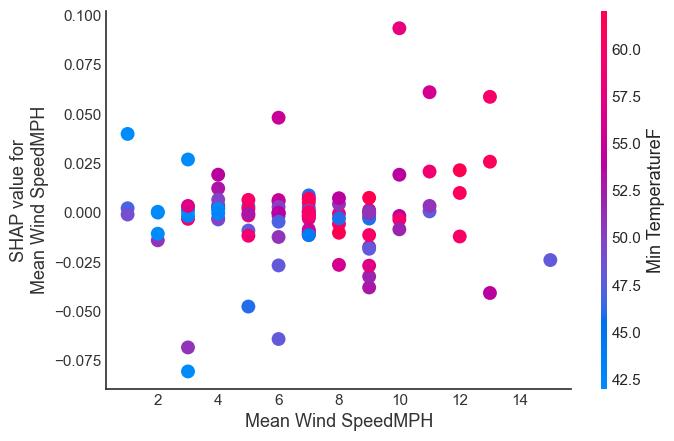

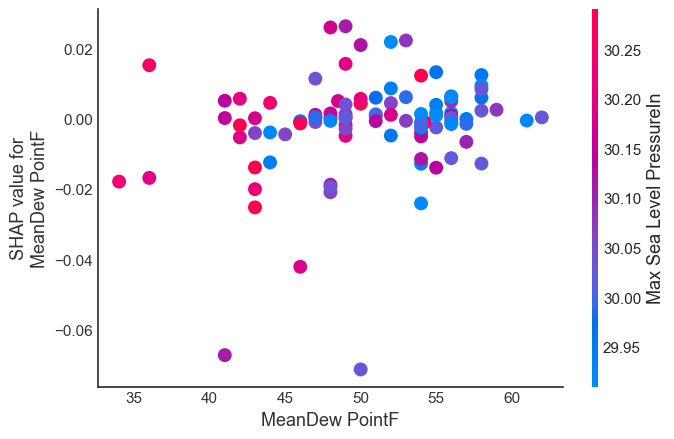

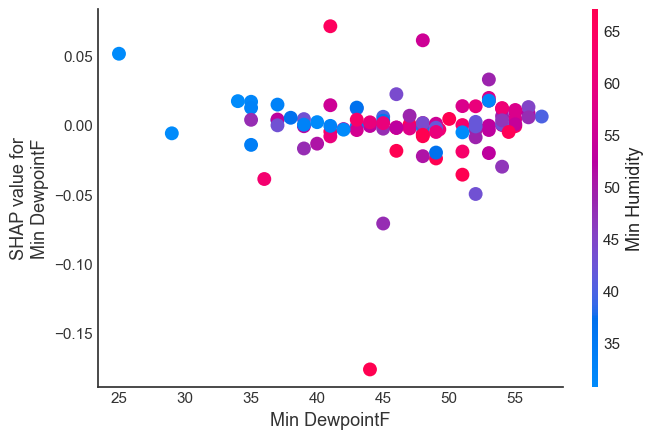

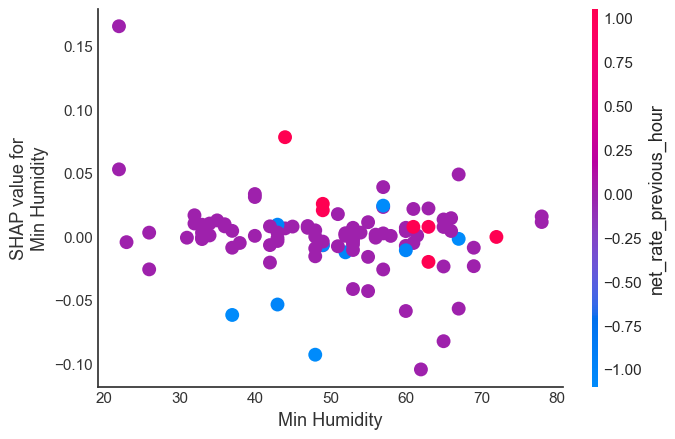

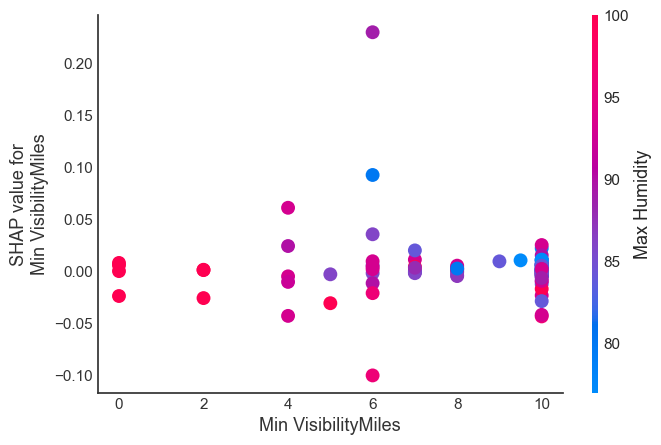

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


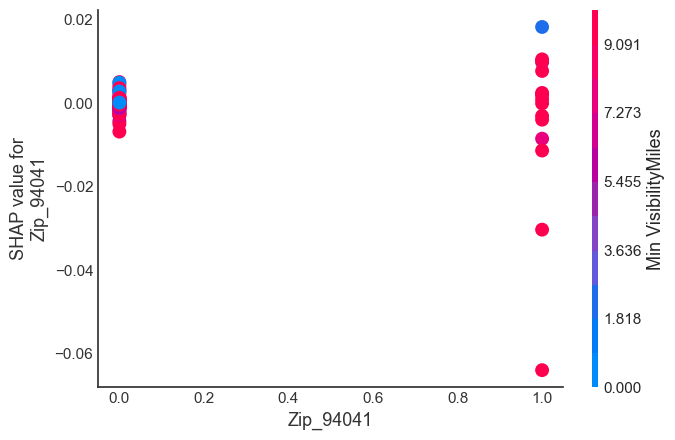

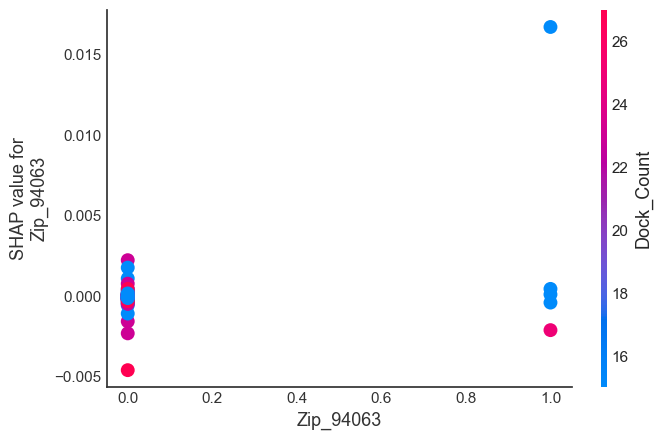

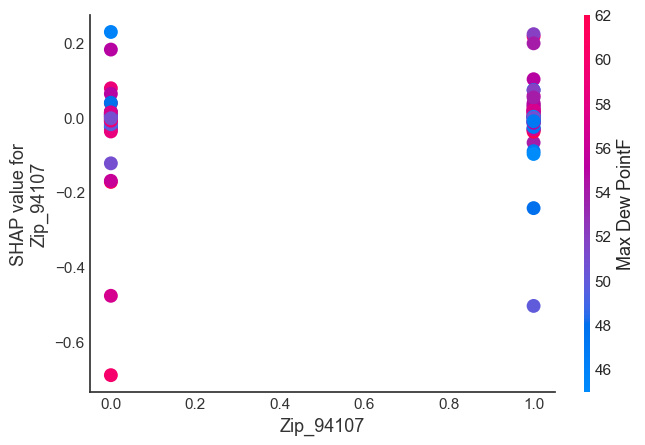

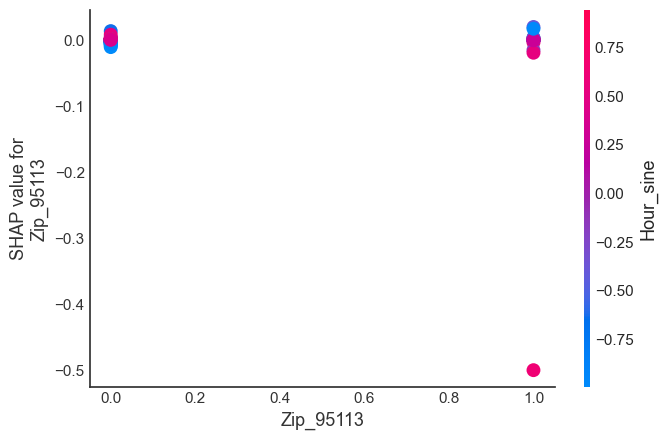

In [269]:
for feat in feature_names:
    shap.dependence_plot(feat, test_shap_vals, X_test[0:100], 
                         dot_size=100)

In [296]:
def shapley(row):
    s_df = pd.DataFrame(test_shap_vals[row.index[0], :][:-1].reshape(40, 1),
                        columns=['Approximate Local Contributions'], index=X.columns[:40])
    s_df = s_df.sort_values(by='Approximate Local Contributions')
    print(s_df, '\n')
    _= s_df.plot(kind='bar', title='Approximate Local Contributions', legend=False)
    print('Shapley sum: ', s_df['Approximate Local Contributions'].sum() + test_shap_vals[row.index[0], -1])
    p = row['predict'].values[0]
    print('Model prediction: ', np.log(p/(1 - p)))

In [297]:
rfr_preds = pd.DataFrame(rfr.predict(X_test)) # or dtest

In [298]:
decile_frame = pd.concat([y_test, rfr_preds], axis=1)
decile_frame = decile_frame.rename(columns={0: 'predict'})

In [299]:
decile = 10
row = decile_frame

                           Approximate Local Contributions
Is_weekday                                       -0.066336
Zip_94107                                        -0.018425
Max Humidity                                     -0.017389
CloudCover                                       -0.013779
Mean TemperatureF                                -0.012184
net_rate_previous_hour                           -0.010012
Season_sine                                      -0.008734
Max Sea Level PressureIn                         -0.006772
Mean Humidity                                    -0.005700
Clear                                            -0.005549
Day_of_week_sine                                 -0.002869
Max VisibilityMiles                              -0.002677
Mean VisibilityMiles                             -0.001731
Hour_cosine                                      -0.001714
Fog                                              -0.001426
PrecipitationIn                                  -0.0011

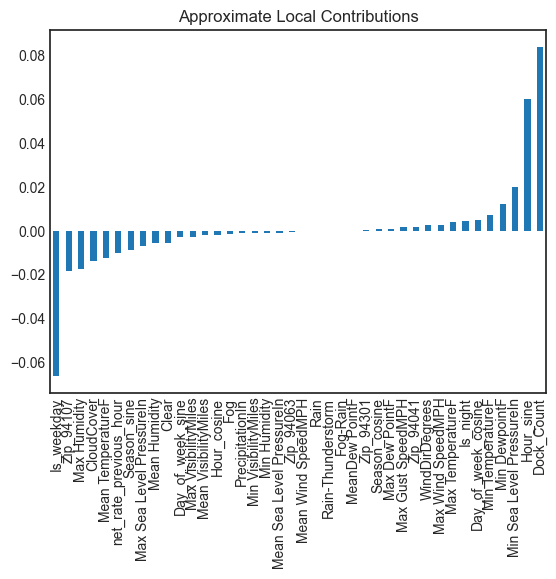

In [300]:
shapley(row)